![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.Spark_OCR.ipynb)

# Spark OCR 

## Colab Setup

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

In [ ]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jsl_colab_setup.sh
!bash jsl_colab_setup.sh

In [ ]:
import os 

os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
ocr_secret = license_keys['SPARK_OCR_SECRET'] 
ocr_version = license_keys['SPARK_OCR_SECRET'].split('-')[0]

! pip install spark-nlp-display
! pip install spark-ocr==$ocr_version'.spark30' --user --extra-index-url=https://pypi.johnsnowlabs.com/$ocr_secret --upgrade


**!!! ATTENTION : After you run this cell ^^ , you need to RESTART the COLAB RUNTIME and RE-RUN the all cells above AGAIN due to Colab predefined settings.**

In [ ]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import os
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

spark = start(secret=license_keys['SPARK_OCR_SECRET'], nlp_secret=license_keys['SECRET'], nlp_version=license_keys['PUBLIC_VERSION'], nlp_internal=license_keys['JSL_VERSION'])
spark

Spark version: 3.0.1
Spark NLP version: 3.0.1
Spark OCR version: 3.0.0



# Pdf to Text 


In [ ]:
!wget -q -O sample_doc.pdf http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf


In [ ]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("image")\
          .setOutputCol("text")\
          .setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

In [ ]:
pdf = 'sample_doc.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()

In [ ]:
result = pipeline().transform(pdf_example_df).cache()

In [ ]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|ASX ANNOUNCEMENT
...|91.79221683078342|
+-------+--------------------+-----------------+



In [ ]:
result.select("text").collect()

[Row(text='ASX ANNOUNCEMENT\n3 November 2017\n\nNotice Pursuant to Paragraph 708A(5)(e) of the Corporations Act\n2001 ("Act")\n\nDigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today\nissued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted\nOptions exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon\nexercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February\n2018.\n\nThe Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt\nunder section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above\nwill fall within the exemption in section 708A(5) of the Act.\n\nThe Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:\n(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of\nthe Act;\n(b) as at the date of this notice, the Company has complied with the provisions of 

In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))


ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they 

###  With Skew Correction

In [ ]:
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
from sparkocr.metrics import score

In [ ]:
def ocr_pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Image skew corrector 
    skew_corrector = ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400_rot.pdf

In [ ]:
pdf_rotated_df = spark.read.format("binaryFile").load('400_rot.pdf').cache()

In [ ]:
pdf_pipeline = ocr_pipeline(False) 

result = pdf_pipeline.transform(pdf_rotated_df).cache()


In [ ]:
result.show()

+--------------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|                path|   modificationTime| length|               image|total_pages|pagenum|documentnum|     corrected_image|       confidence|exception|                text|           positions|
+--------------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+
|file:/content/400...|2021-04-13 14:49:13|2240141|[file:/content/40...|          1|      0|          0|[file:/content/40...|95.88622707790799|         |FOREWORD

Electro...|[[[[FOREWORD

, 0...|
+--------------------+-------------------+-------+--------------------+-----------+-------+-----------+--------------------+-----------------+---------+--------------------+--------------------+



In [ ]:
result.select("pagenum").collect()[0].pagenum

0

Image:
        origin: file:/content/400_rot.pdf 
        width: 2480
        height: 3507
        mode: 10


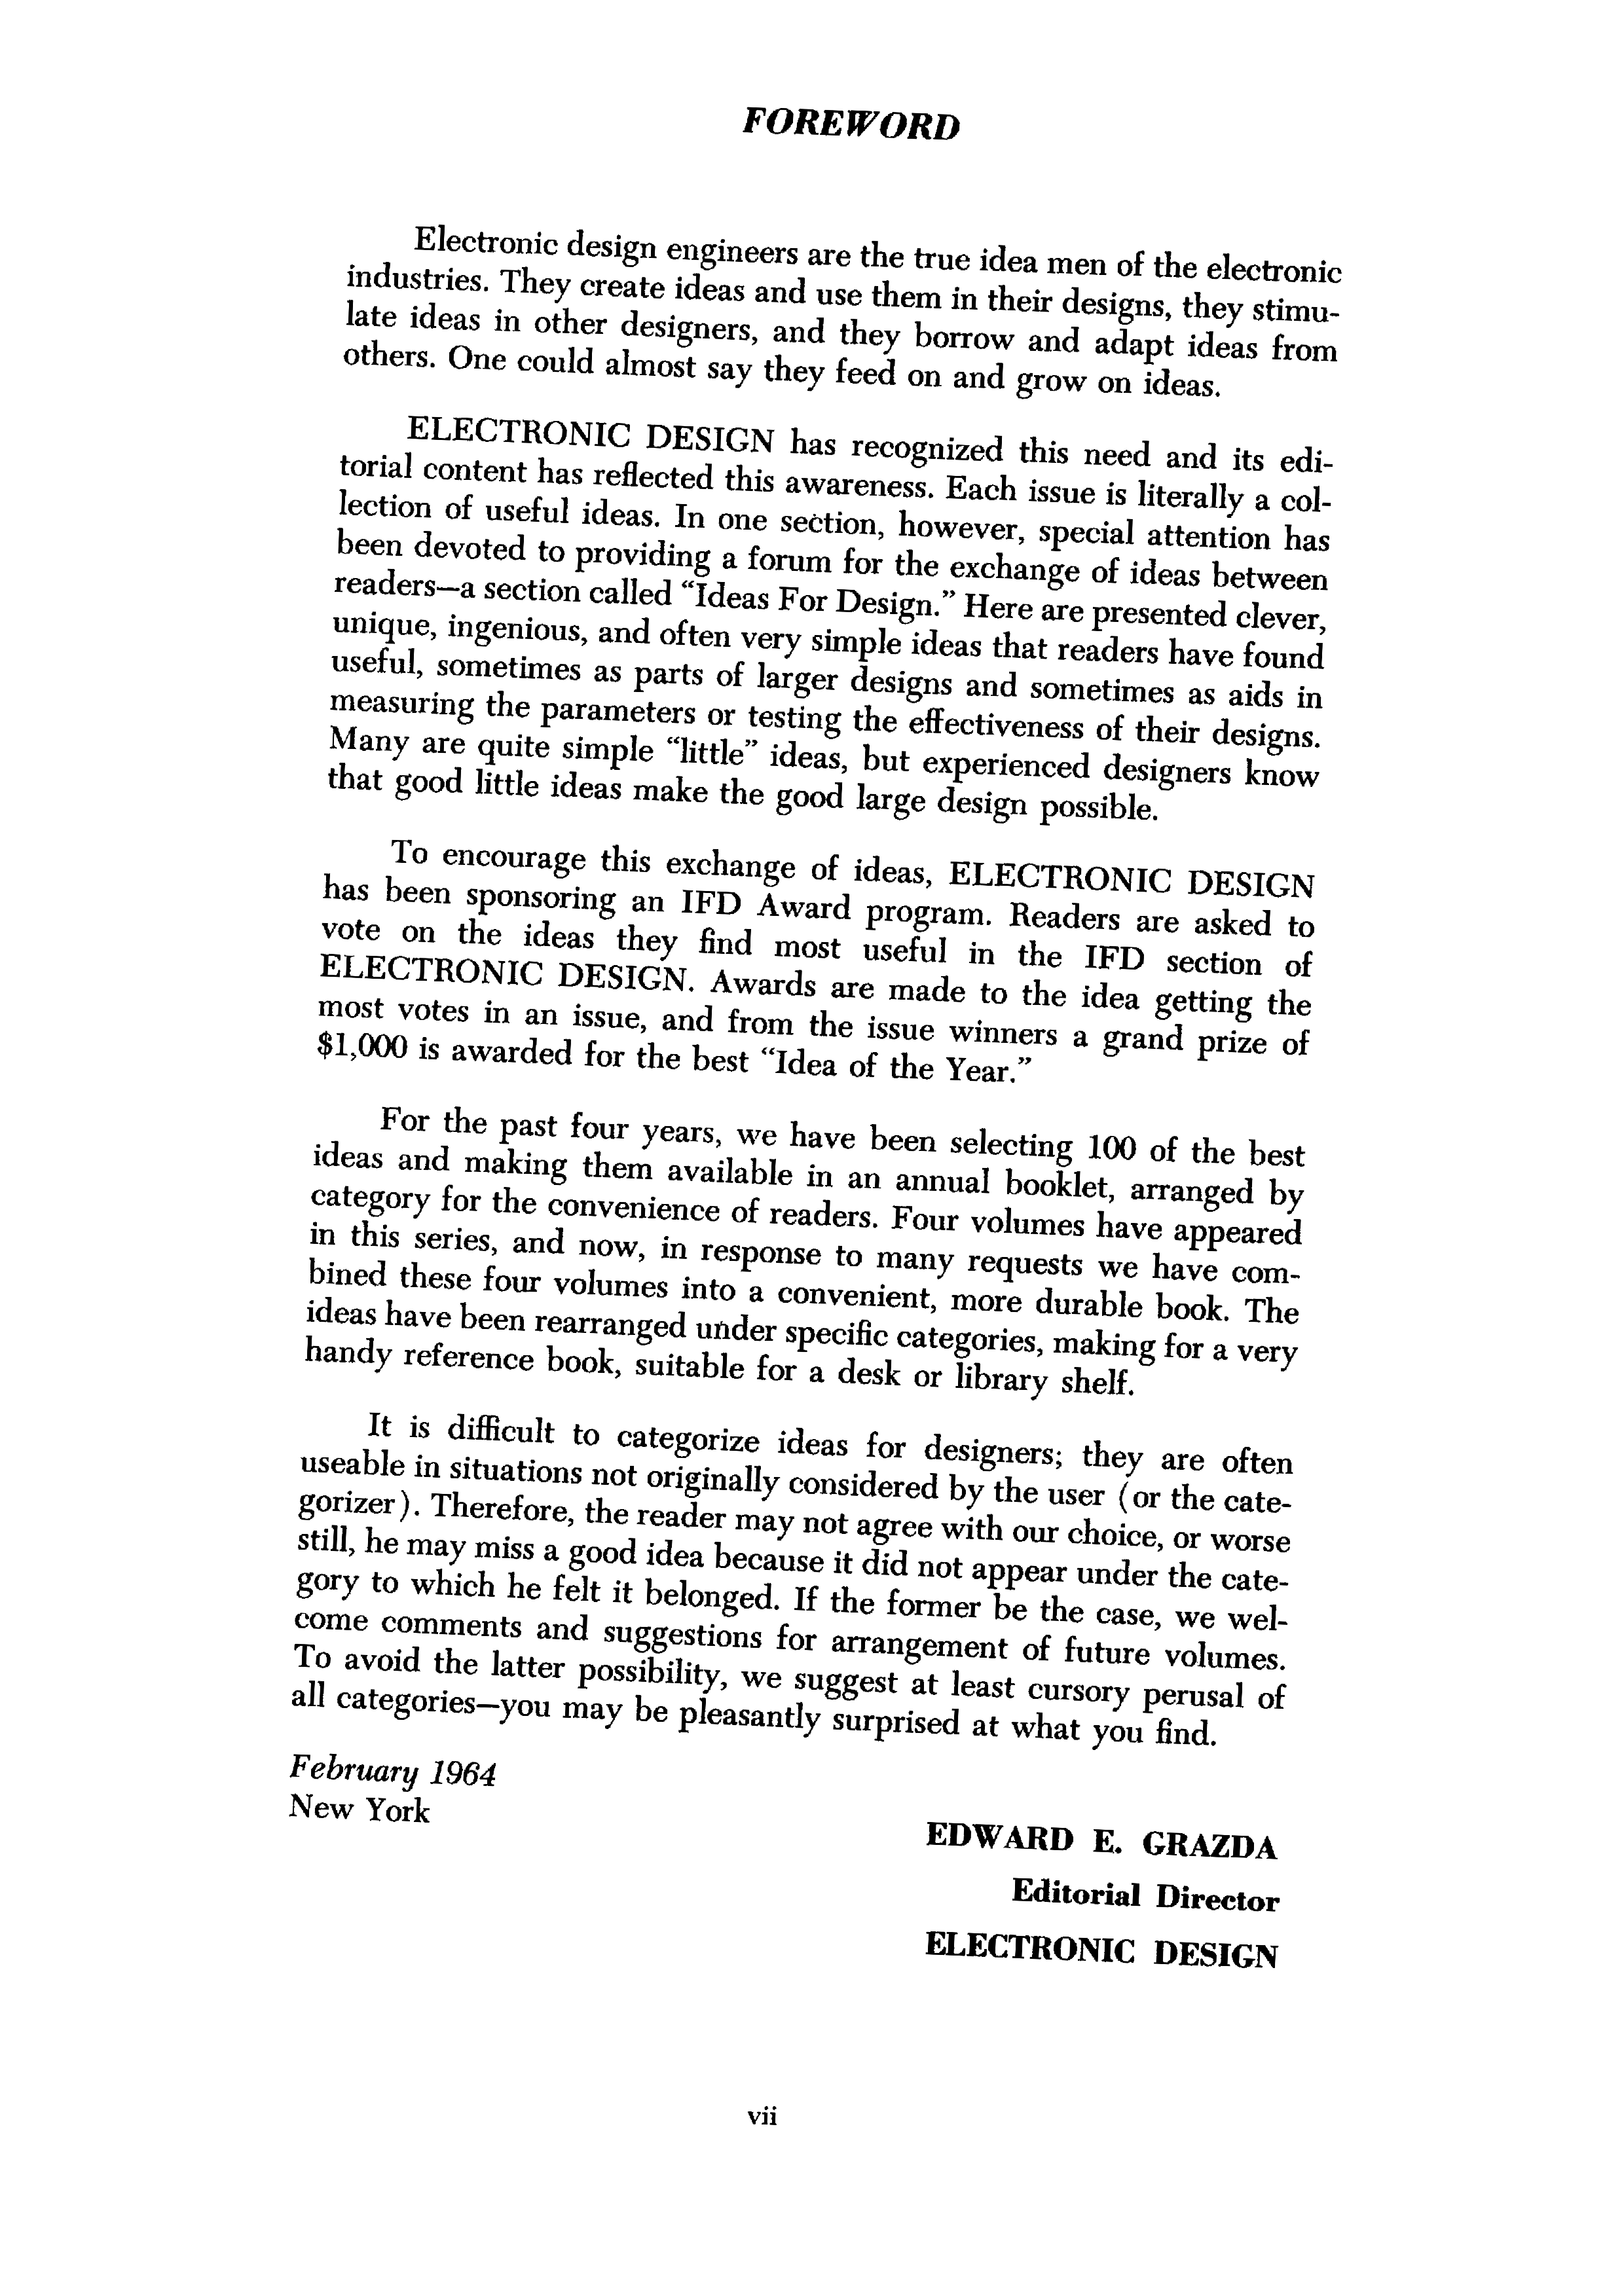

In [ ]:
display_image(result.select("image").collect()[0].image)

### Display recognized text without skew correction


In [ ]:
result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|95.88622707790799|
+-------+--------------------+-----------------+



In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by

It is difficult to categorize ideas for designers; they are often
useable in situations not originally considered by the user (or the cate-

come comments and suggestions for arrangement of future volumes.
To avoid the latter possibility, we suggest at least cursory perusal of
all categories—you may be pleasantly surprised at what yo

### Display results with skew correction

In [ ]:
pdf_pipeline = ocr_pipeline(True) 

corrected_result = pdf_pipeline.transform(pdf_rotated_df).cache()

print("\n".join([row.text for row in corrected_result.select("text").collect()]))


FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

In [ ]:
corrected_result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|96.03673458099365|
+-------+--------------------+-----------------+



### Display skew corrected images

Image:
        origin: file:/content/400_rot.pdf 
        width: 2600
        height: 3591
        mode: 10


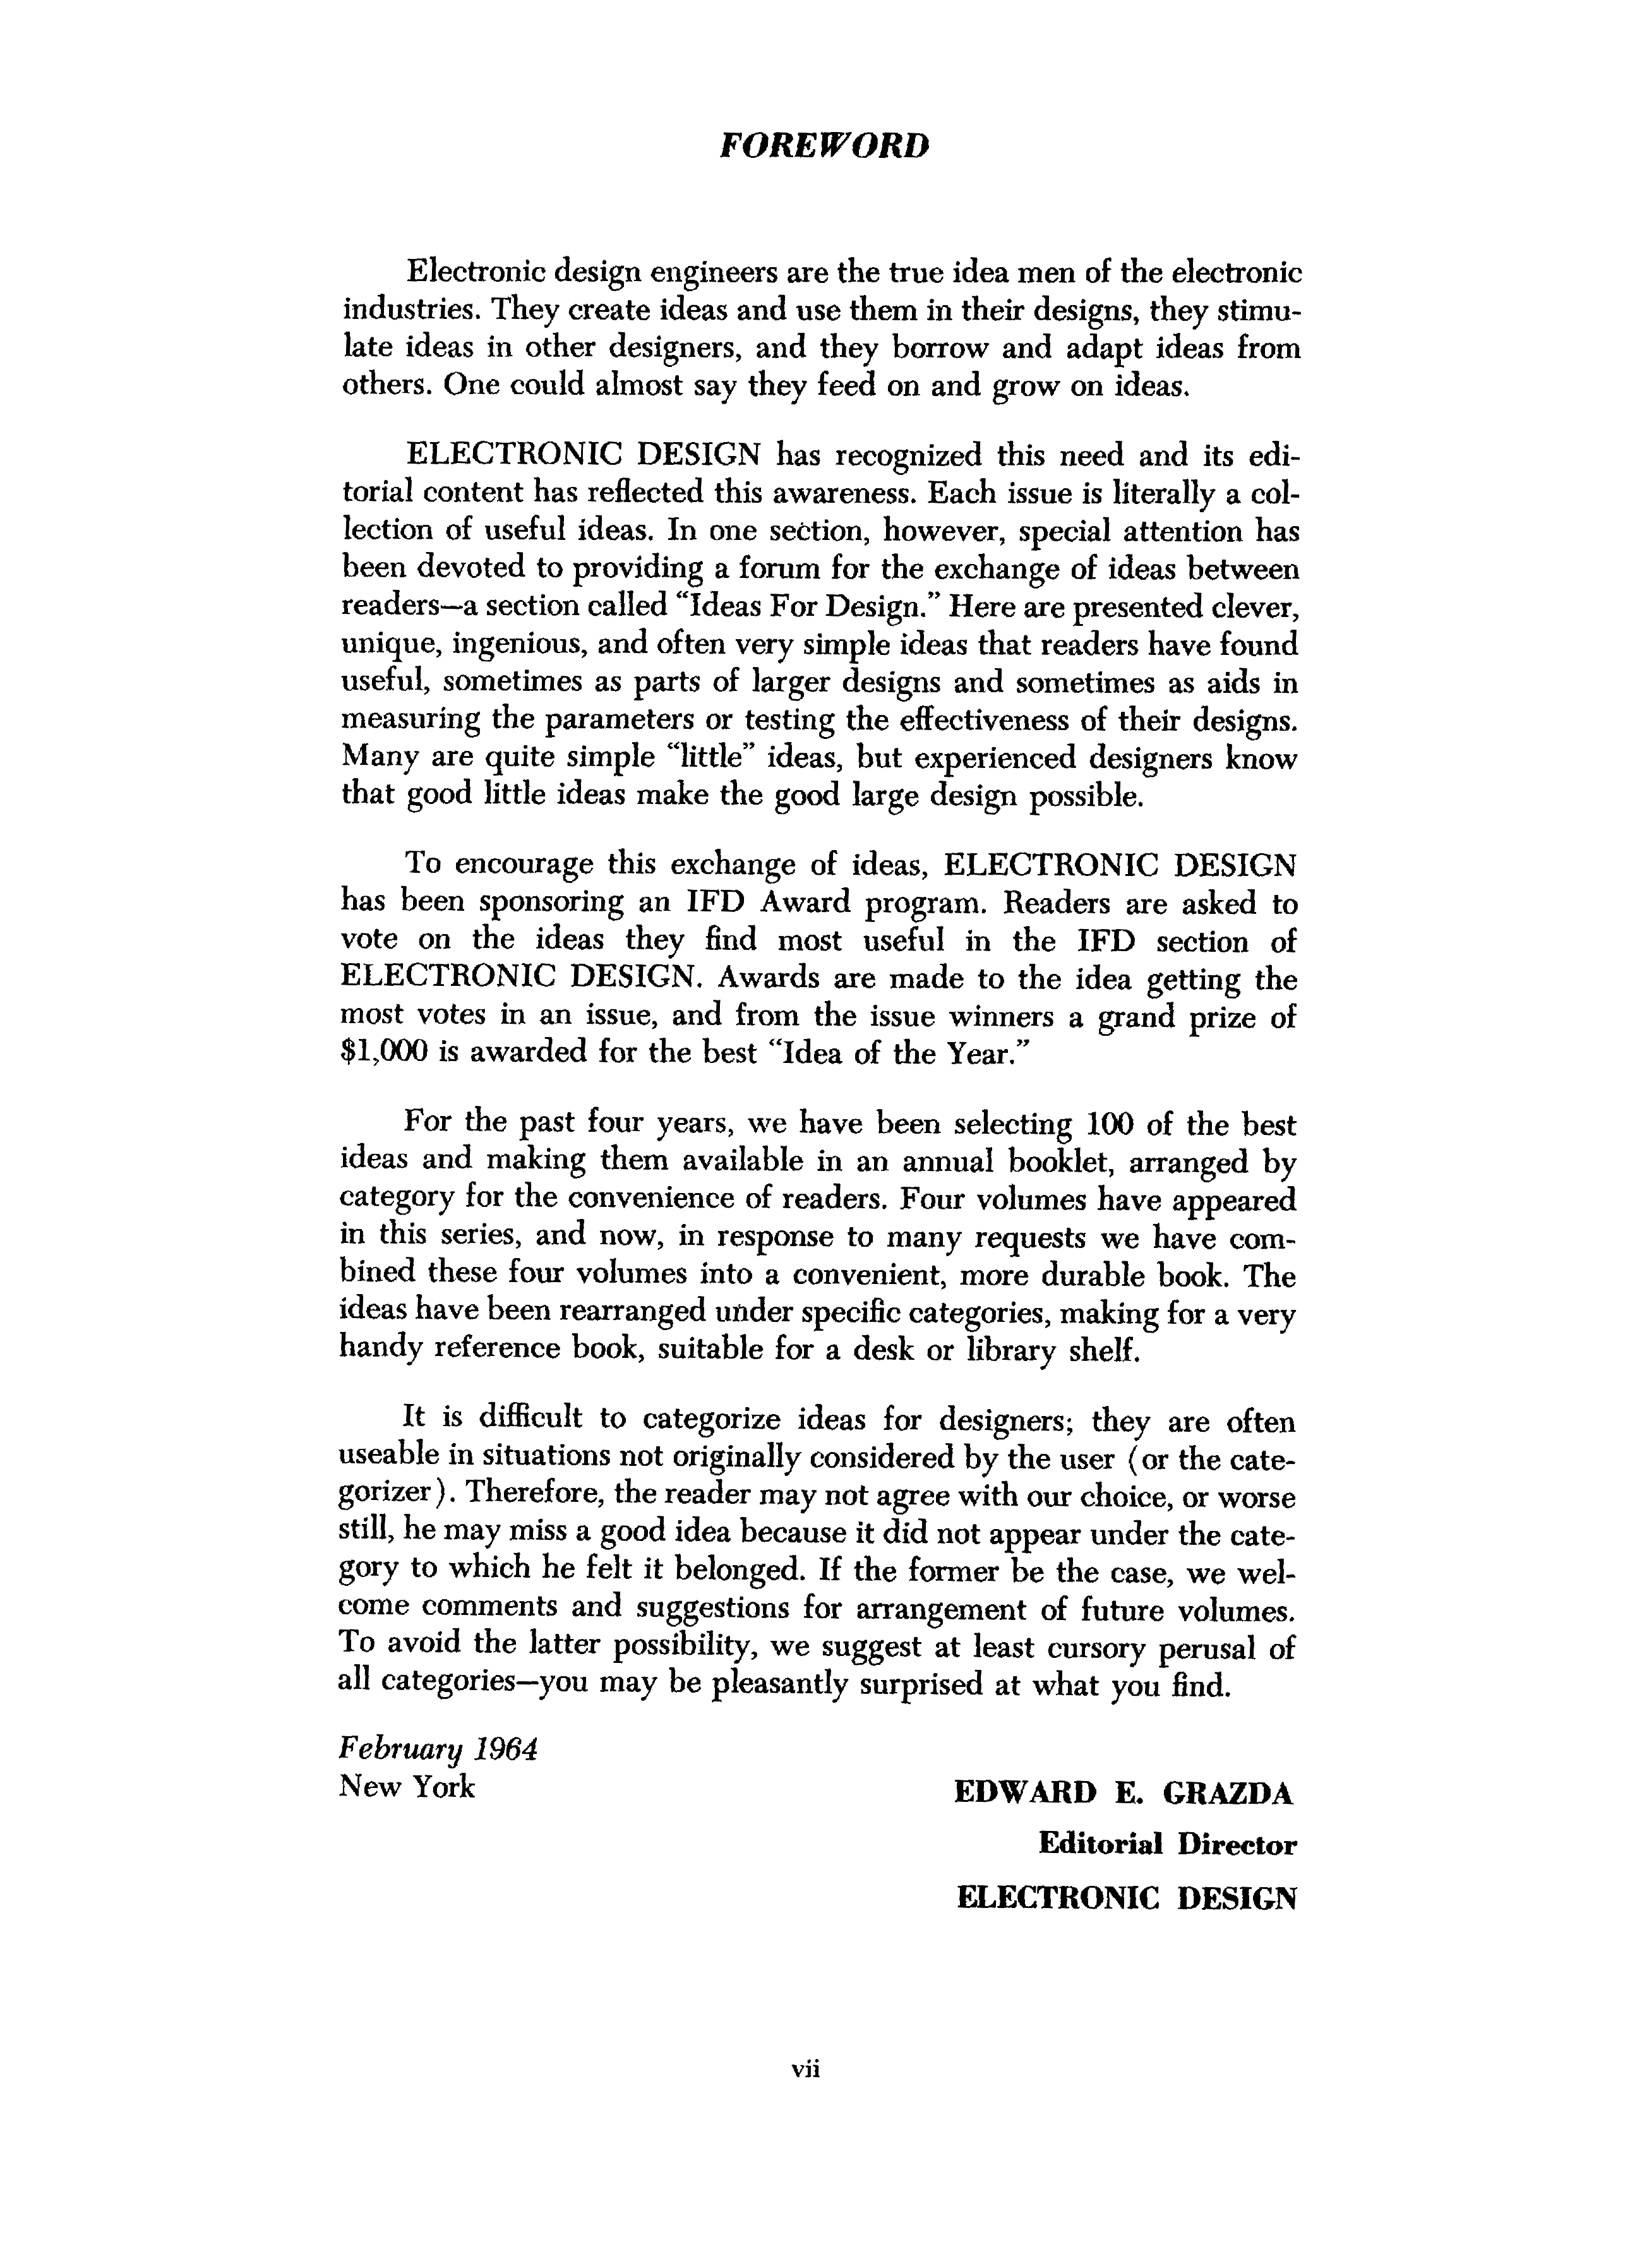

In [ ]:
display_image(corrected_result.select("corrected_image").collect()[0].corrected_image)

## Compute score and compare
Read original text and calculate scores for both results.

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/400.txt

In [ ]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
pdf_rotated_text = open('400.txt', "r").read()

# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.5780748663101604
Score with skew correction: 0.9535615899252263


## Reading multiple pdfs from folder

In [ ]:
pdf_path = "/content/*.pdf"

pdfs = spark.read.format("binaryFile").load(pdf_path).cache()
#images = spark.read.format("binaryFile").load('text_with_noise.png').cache()

pdfs.count()

2

In [ ]:
# Transforrm PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)\
      .setIgnoreResolution(False)

ocr_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])


In [ ]:
results = ocr_pipeline.transform(pdfs)


In [ ]:
results.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'confidence',
 'exception',
 'text',
 'positions']

In [ ]:
results.select('path','confidence','text').show()

+--------------------+-----------------+--------------------+
|                path|       confidence|                text|
+--------------------+-----------------+--------------------+
|file:/content/400...|95.71951103210449|FOREWORD

Electro...|
|file:/content/sam...|95.18117046356201|ASX ANNOUNCEMENT
...|
+--------------------+-----------------+--------------------+



## Image processing after reading a pdf

In [ ]:
from sparkocr.enums import *

# Read binary as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image")\
  .setResolution(400)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()\
  .setKernelShape(KernelShape.SQUARE)\
  .setOperation(MorphologyOperationType.OPENING)\
  .setKernelSize(3)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeObject(130)

# Image Layout Analyzer for detect regions
image_layout_analyzer = ImageLayoutAnalyzer()\
  .setInputCol("corrected_image")\
  .setOutputCol("region")\

draw_regions = ImageDrawRegions()\
  .setInputCol("corrected_image")\
  .setInputRegionsCol("region")\
  .setOutputCol("image_with_regions")

# Run tesseract OCR for corrected image
ocr_corrected = ImageToText()\
  .setInputCol("corrected_image")\
  .setOutputCol("corrected_text")\
  .setPositionsCol("corrected_positions")\
  .setConfidenceThreshold(65)

# Run OCR for original image
ocr = ImageToText()\
  .setInputCol("image")\
  .setOutputCol("text")

# OCR pipeline
image_pipeline = PipelineModel(stages=[
    pdf_to_image,
    binarizer,
    opening,
    remove_objects,
    image_layout_analyzer,
    draw_regions,
    ocr,
    ocr_corrected
])

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/pdfs/noised.pdf


In [ ]:
image_df = spark.read.format("binaryFile").load('noised.pdf').cache()
image_df.show()

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/content/noi...|2021-04-13 14:49:54|2115939|[25 50 44 46 2D 3...|
+--------------------+-------------------+-------+--------------------+



In [ ]:
result = image_pipeline \
.transform(image_df) \
.cache()

In [ ]:
for r in result.distinct().collect():
  
    print("Original: %s" % r.path)
    display_image(r.image)

    print("Corrected: %s" % r.path)
    display_image(r.corrected_image)

Output hidden; open in https://colab.research.google.com to view.

### Results with original image

In [ ]:
from termcolor import colored

grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.text)

Filename:
file:/content/noised.pdf , page: 0
Recognized text:
 

Wels a Me a te ee a ' Date: . 1/36/68
Ce ES ota ~ Sample No. _ 5031 -. eae PTL ood :
“ Original request made by Mr. C. L. Tucker, Jr. ° on pa tot
Sample specifications written by _John H. M. Bohlken - 5
OI Be BON KER
, BLEND CASING RECASING ' FINAL FLAVOR MENTHOL FLAVOR
“OLD GOLD STRAIGHT Tobacco Blend : = a — " of
- Control. for Sample 1 No. 5030 at | 3 Ee a
*. Gigarettes: | ~
. Brana ------~-- OLD GOLD STRAIGHT
'. Length --------- 85 mm.
Circumference--~ 25.3 mn. o
Paper ~---------- Ecusta 556 ;
Firmness -----~- OLD GOLD STRAIGHT .
Draw -----~-+~-~-~-~~ OLD GOLD STRAIGHT | .,
Weight -------~- OLD GOLD STRAIGHT wrappings: .
Tipping Paper -- _ oa. , . .
abels ----
Print-----~----— OLD GOLD STRAIGHT slennneen Stongona STRAIGHT
C - Filter Length--- —-
~ _ Tear Tape-- Gold
. . Cartons --- OLD GOLD STRAIGHT
: =. Requirements: “ss 8 .. Markings-- Sample number on each
Ts . ‘pack and carton
Laboratory ----- One Tray oe

Others 

### Results with corrected image


In [ ]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("corrected_text")).alias("corrected_text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.corrected_text)

Filename:
file:/content/noised.pdf , page: 0
Recognized text:
 

- > Date: 7/16/68
Sample No. _ 5031 >
° Oraginal request made by Mr. €. L Tucker, Jr. on ‘7/10/68
Sample specifications written by John H. M. Bohlken
, BLEND CASING RECASING FINAL FLAVOR MENTHOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

° Control for Sample No. 5030

Cigarettes:

Brand -<--------= OLD GOLD STRAIGHT

Length --------- 85 mm.

Circumference~-~ 25.3 mn.

Paper eee eee ee Ecusta 556

Firymness -----—-. OLD GOLD STRAIGHT

Draw ---—---~-~~——. OLD GOLD STRAIGHT

Weaght mee eee OLD GOLD STRAIGHT Wra inds ‘

Tipping Paper -- --

Print----------- OLD GOLD STRAIGHT pees “777 OLD GOLD STRAIGHT
C Filter Length--- __ Closures--- Standard Blue

~ Tear Tape-- Gold
. Cartons --- OLD GOLD STRAIGHT

- Requirements _ Markings-~ Sample number on each

Laboratory ----- One Tray . pack and carton

Others ----~-----

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — 7-16 -CF~ C2 VOSS 1 F

In [ ]:
result.columns

['path',
 'modificationTime',
 'length',
 'image',
 'total_pages',
 'pagenum',
 'documentnum',
 'binarized_image',
 'opening_image',
 'corrected_image',
 'region',
 'image_with_regions',
 'confidence',
 'text',
 'positions',
 'confidence',
 'exception',
 'corrected_text',
 'corrected_positions']

### Abby output

In [ ]:
abbyy = """-----
% Date: 7/16/68
X*: I; * • ■ Sample No. 5031___ — .*
•* Original request made by _____Mr. C. L. Tucker, Jr. on
Sample specifications written by
BLEND CASING RECASING
OLD GOLD STRAIGHT Tobacco Blend
Control for Sample No. 5030
John H. M. Bohlken
FINAL FLAVOR
) 7/10/68
MENTHOL FLAVOR
• Cigarettes; * . .v\ . /,*, *, S •
Brand --------- OLD GOLD STRAIGHT -V . ••••
; . L e n g t h ------- — 85 mm. . : '
Circumference-- 25.3 mm. • ' *;. • •
P a p e r ---------- Ecusta 556 • * .
F i r m n e s s---- —— OLD GOLD STRAIGHT . ! •■'
D r a w ___________ OLD GOLD STRAIGHT
W e i g h t --------- 0LD GOLD STRAIGHT Wrappings: « -
Tipping Paper — — *
p H n f —. — — _ _ ~ L a b e l s ----OLD GOLD STRAIGHT
( • Filter Length-- . — Closures--- Standard Blue .
^ ^ ; • Tear Tape— Gold
Cartons --- OLD GOLD STRAIGHT
s Requirements: . - •' • Markings-- Sample number on each
• pack and carton Laboratory----- One Tray .
O t h e r s --------- * , s • • . 4
Laboratory A n a l ysis^ I " '/***• * 7 ' ^ ^
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — J-ZZ-Zf'- (£. / •
Responsibility;
Tobacco B l e n d ------Manufacturing - A. Kraus . . * -
Filter Production--- —
• Making & P a c k i n g---Product Development , John H. M. Bohlken
Shipping -----------
Reports:
t
Written by — John H. M. Bohlken
Original to - Mr. C. L. Tucker, Jr.
Copies t o ---Dr. A. W. Spears
• 9 ..
"""

#### Display original and corrected images with regions


In [ ]:
for r in result.select("path","image","image_with_regions").distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Corrected: %s" % r.path)
    display_image(r.image_with_regions)

Output hidden; open in https://colab.research.google.com to view.

# Image (or Natural Scene) to Text

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png


Original: file:/content/text_with_noise.png
Image:
        origin: file:/content/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


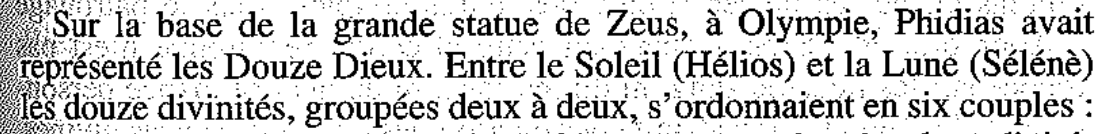

Binarized
Image:
        origin: file:/content/text_with_noise.png 
        width: 2190
        height: 268
        mode: 12


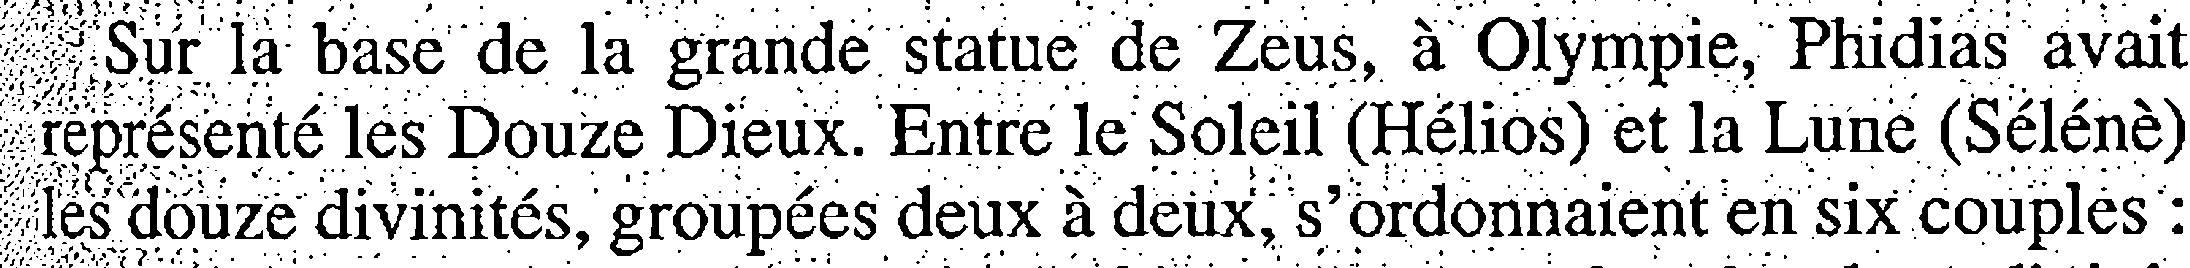

Removing objects
Image:
        origin: file:/content/text_with_noise.png 
        width: 2190
        height: 268
        mode: 12


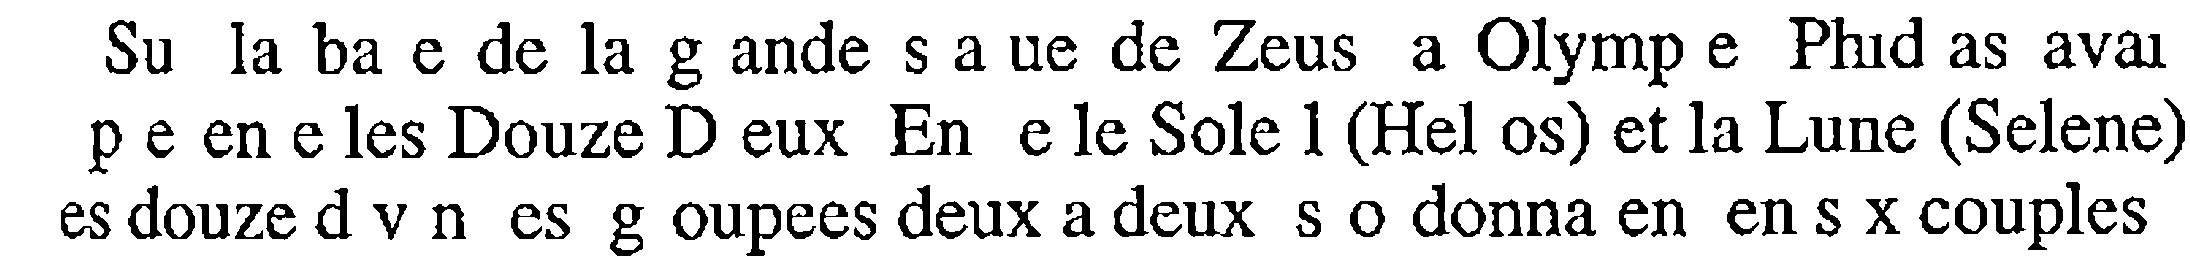

In [ ]:
image_df = spark.read.format("binaryFile").load('text_with_noise.png').cache()

# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(71)
binarizer.setOffset(65)

remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("binarized_image")
remove_objects.setOutputCol("cleared_image")
remove_objects.setMinSizeObject(400)
remove_objects.setMaxSizeObject(4000)

# Run OCR
ocr = ImageToText()
ocr.setInputCol("cleared_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
noisy_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    ocr
])


result = noisy_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objects")
    display_image(r.cleared_image)


In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

Su la ba e de la g ande saue de Zeus a Olympe Phid as avai
pe eneles Douze D eux En ele Sole | (Hel os) et la Lune (Selene)
esdouze dv n es g oupees deux adeux s o donna en ens x couples



### Text from Scene

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/natural_scene.jpeg

Original: file:/content/natural_scene.jpeg
Image:
        origin: file:/content/natural_scene.jpeg 
        width: 640
        height: 480
        mode: 10


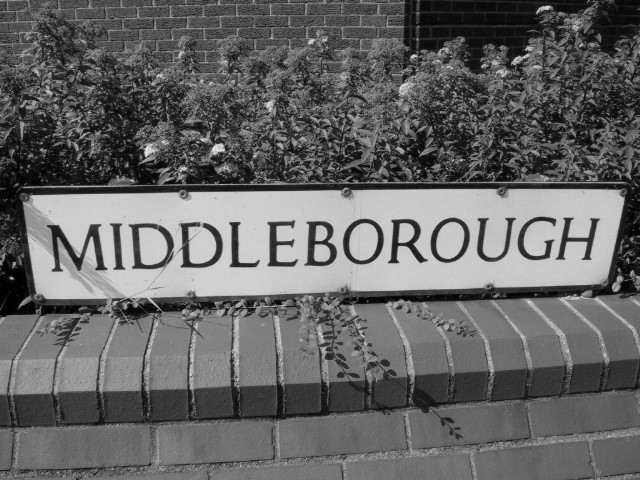

Binarized
Image:
        origin: file:/content/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 12


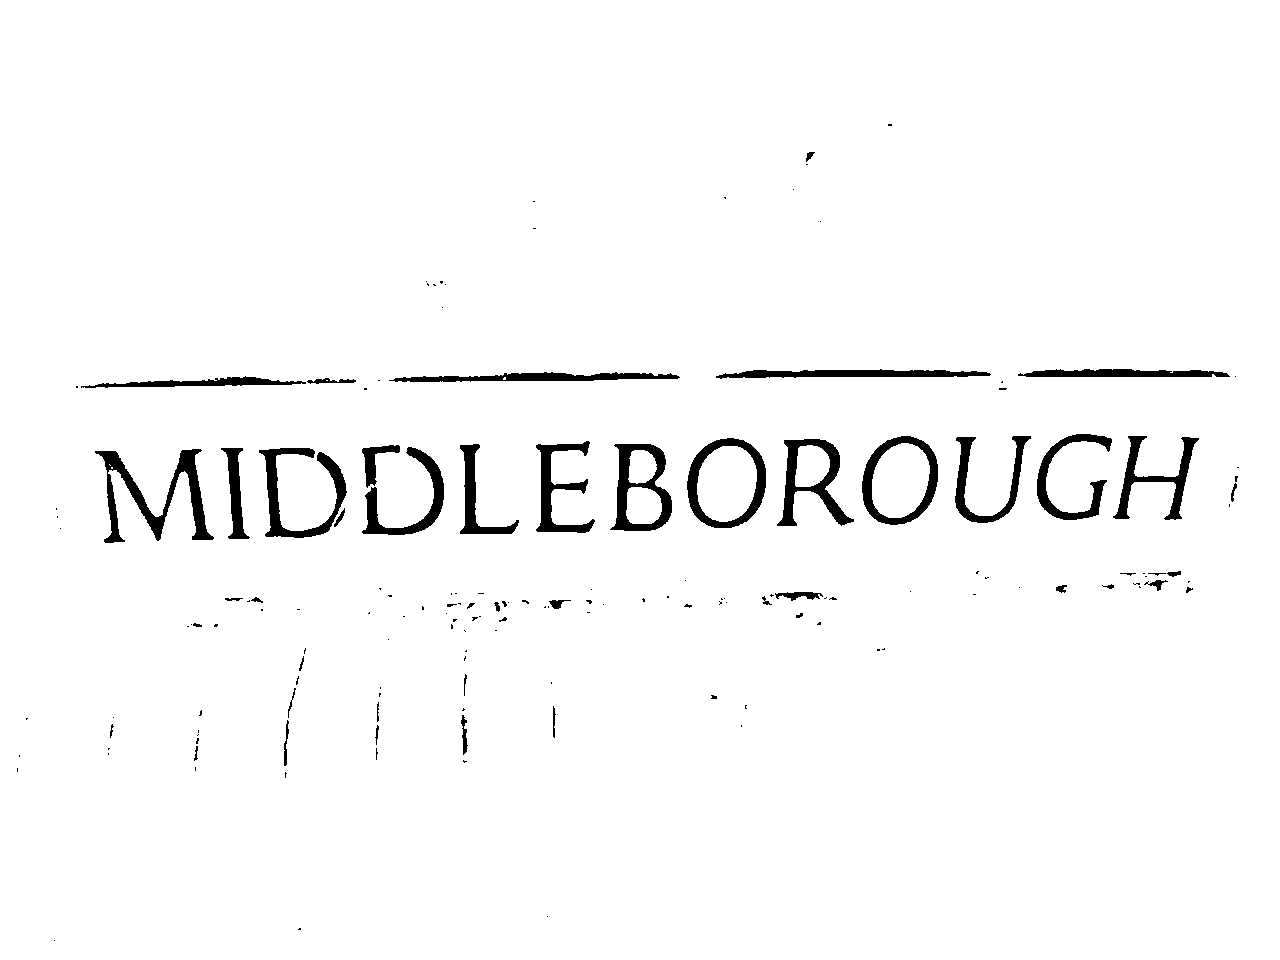

Removing objects
Image:
        origin: file:/content/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 12


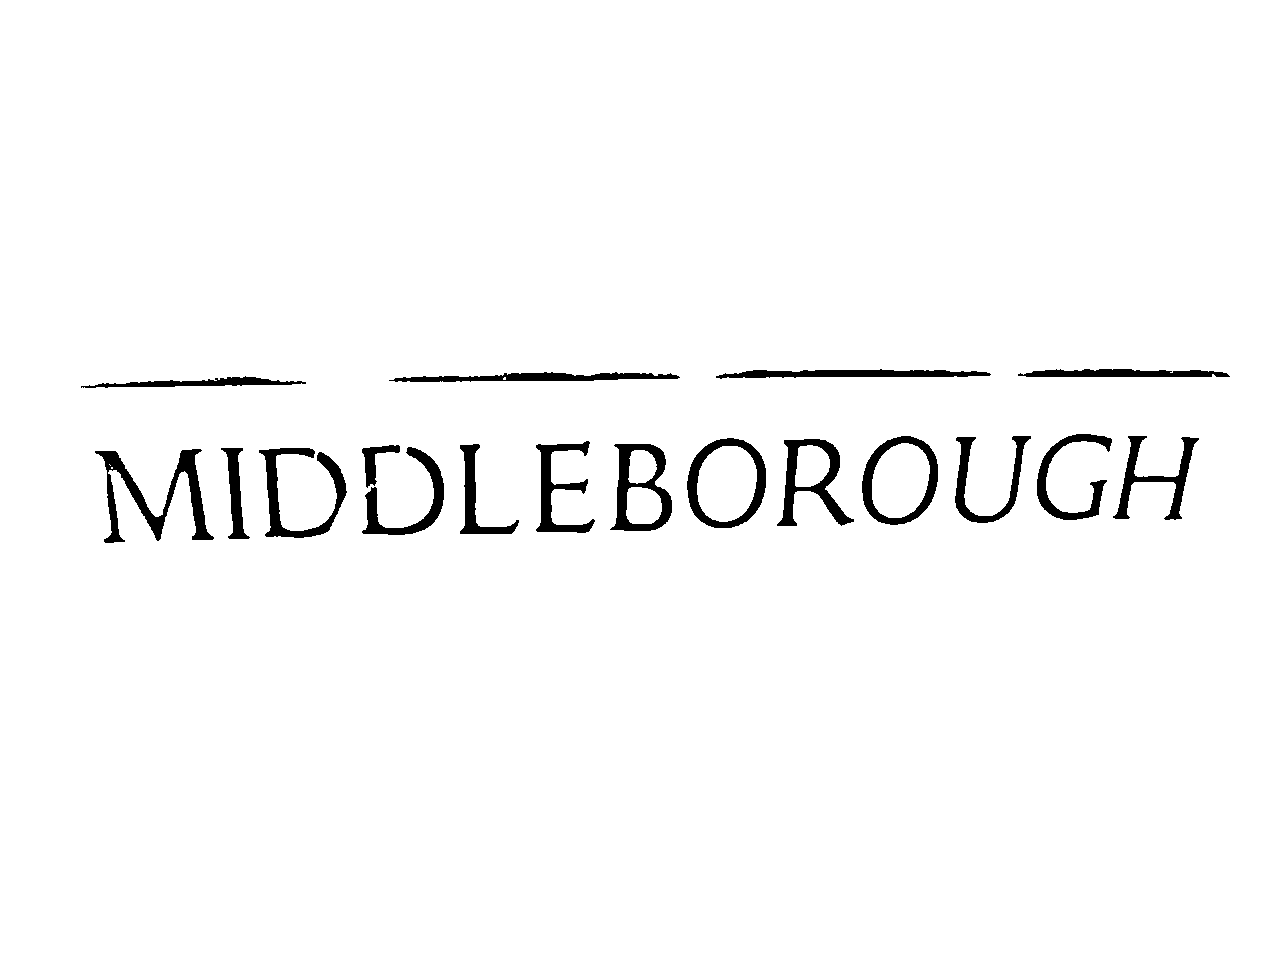

Morphology closing
Image:
        origin: file:/content/natural_scene.jpeg 
        width: 1280
        height: 960
        mode: 12


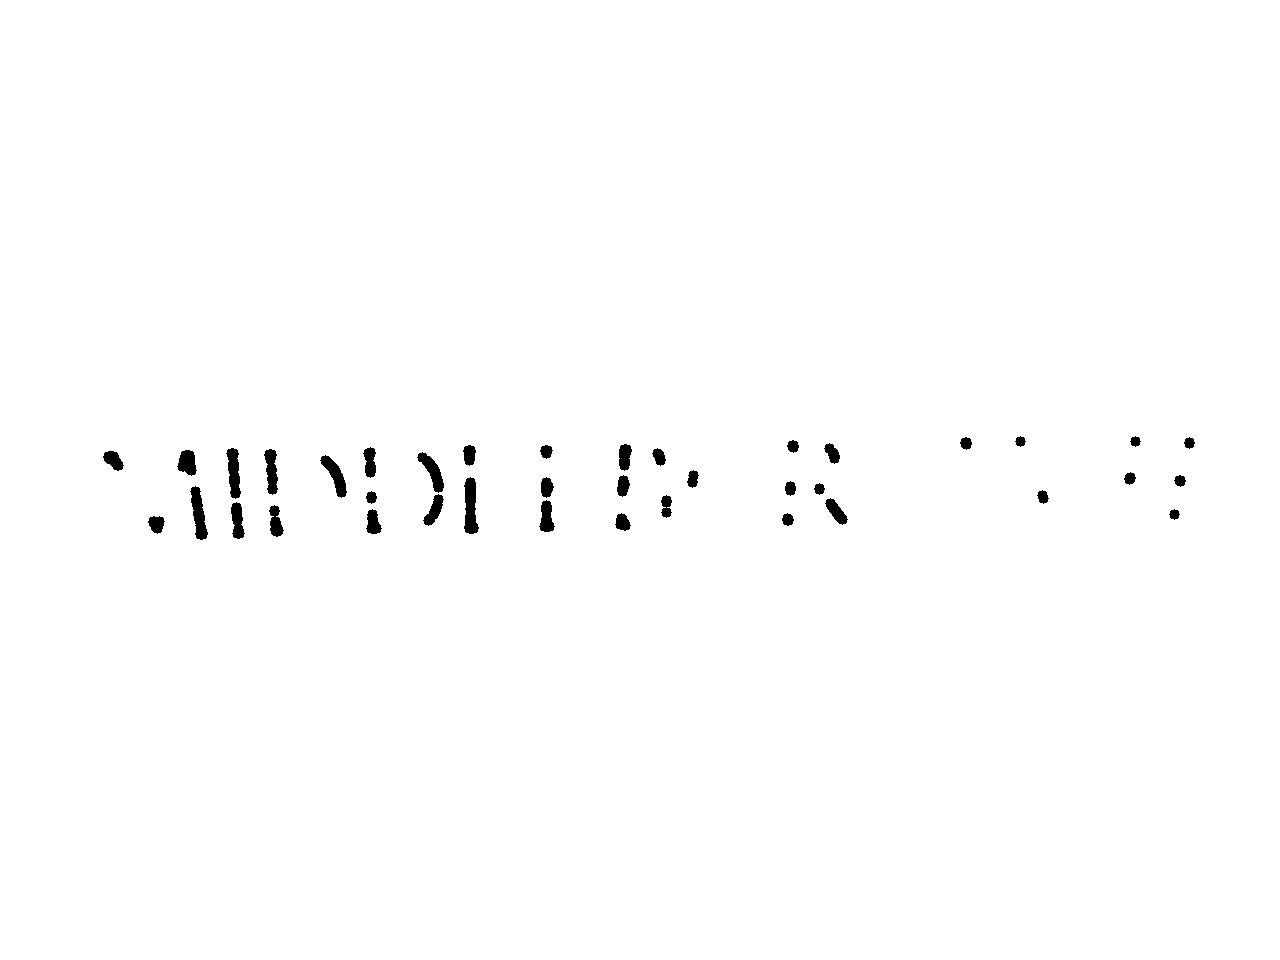

In [ ]:
image_df = spark.read.format("binaryFile").load('natural_scene.jpeg').cache()

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(5)
morpholy_operation.setOperation("closing")
morpholy_operation.setInputCol("cleared_image")
morpholy_operation.setOutputCol("corrected_image")

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# OCR pipeline
scene_pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

result = scene_pipeline \
.transform(image_df) \
.cache()


for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized")
    display_image(r.binarized_image)
    print("Removing objects")
    display_image(r.cleared_image)
    print("Morphology closing")
    display_image(r.corrected_image)

# DOCX Processing (version 1.10.0)

#### Read DOCX document as binary file

In [ ]:
import pkg_resources
doc_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')
doc_example_df = spark.read.format("binaryFile").load(doc_example).cache()

## DocxtoText

#### Extract text using DocToText transformer

In [ ]:
from sparkocr.transformers import *

doc_to_text = DocToText()
doc_to_text.setInputCol("content")
doc_to_text.setOutputCol("text")

result = doc_to_text.transform(doc_example_df)

#### Display result DataFrame

In [ ]:
result.show()

+--------------------+-------------------+------+--------------------+---------+-------+
|                path|   modificationTime|length|                text|exception|pagenum|
+--------------------+-------------------+------+--------------------+---------+-------+
|file:/root/.local...|2021-04-13 14:44:02| 33260|Sample Document
T...|     null|      0|
+--------------------+-------------------+------+--------------------+---------+-------+



#### Display extracted text

In [ ]:
print("\n".join([row.text for row in result.select("text").collect()]))

Sample Document
This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.
Headings
There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headings.
Lists
The following outline of the sections of this document is an ordered (numbered) list with six items. The fifth item, "Tables," contains a nested unordered (bulleted) list with two items.
Headings 
Lists 
Links 
Images 
Tables 
Simple Tables 
Complex Tables 
Columns 
Links
In web documents, links can point different locations on the page, different pages, or even downloadable documents, such as Word documents or PDFs:
Top of this Page
Sample Document
Sa

## DocxToTextTable
#### (Extracting table data from Microsoft DOCX documents)

#### Preview document using DocToPdf and PdfToImage transformers

Image:
        origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


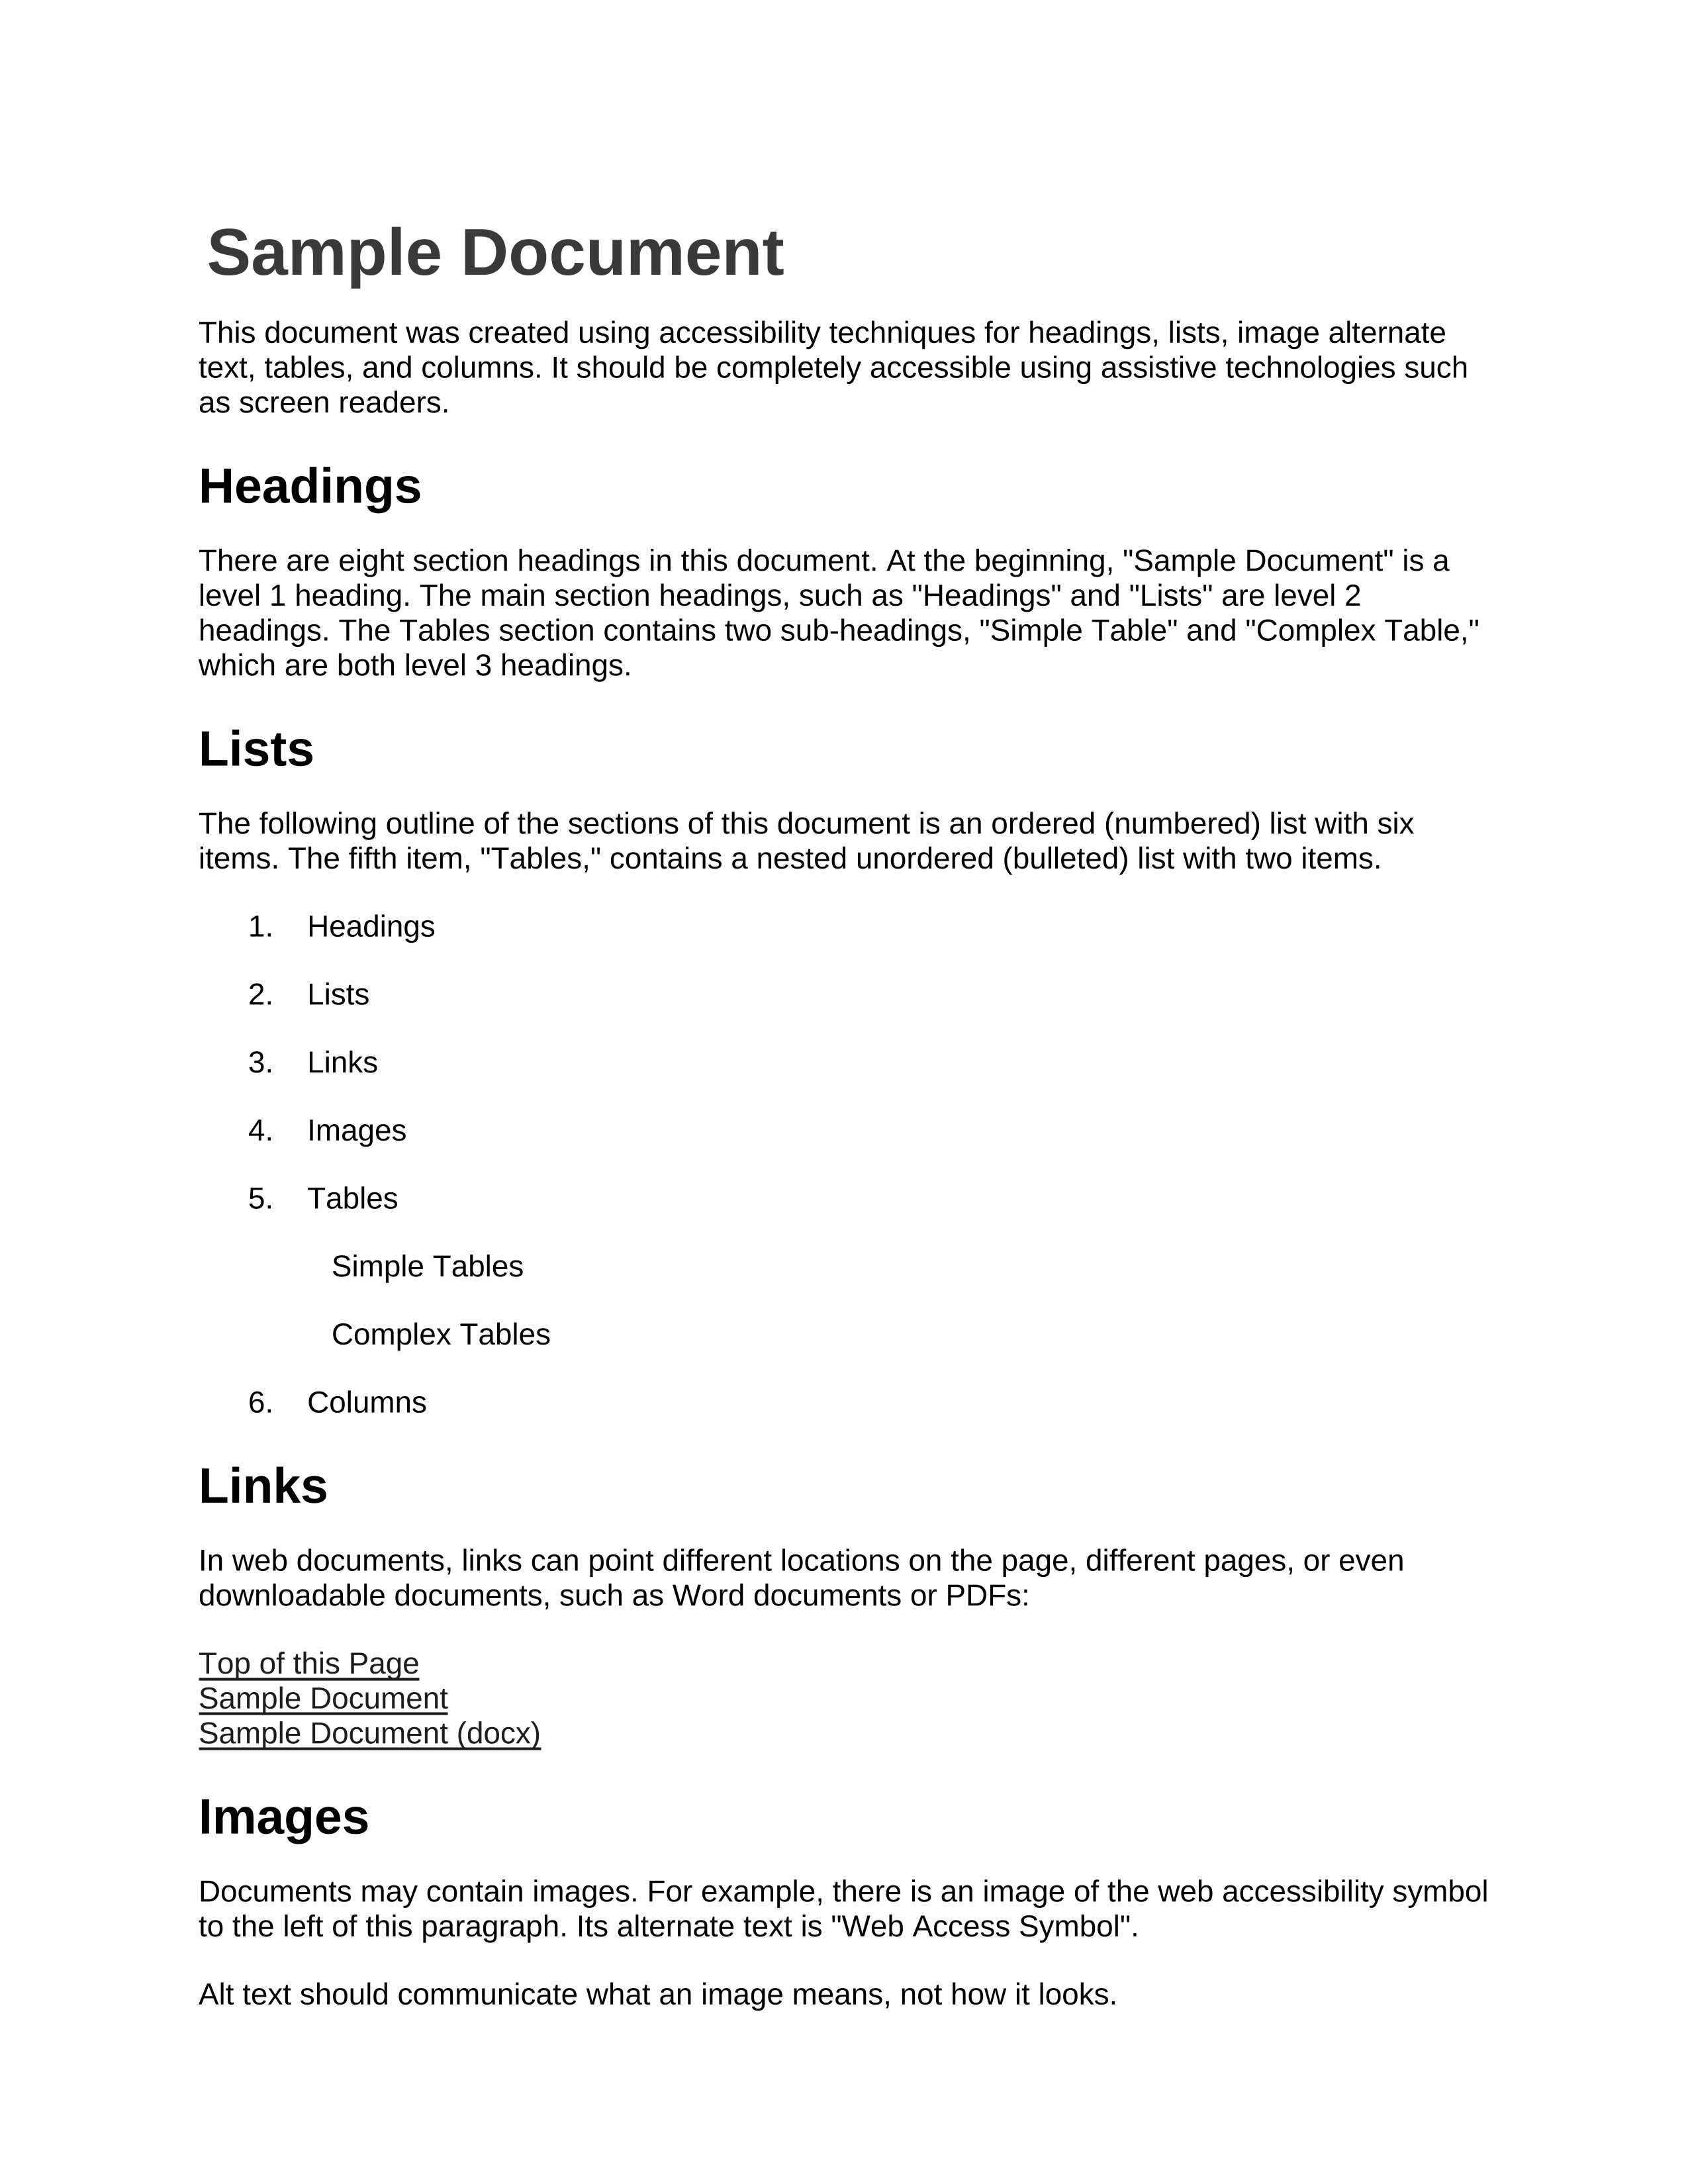

Image:
        origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


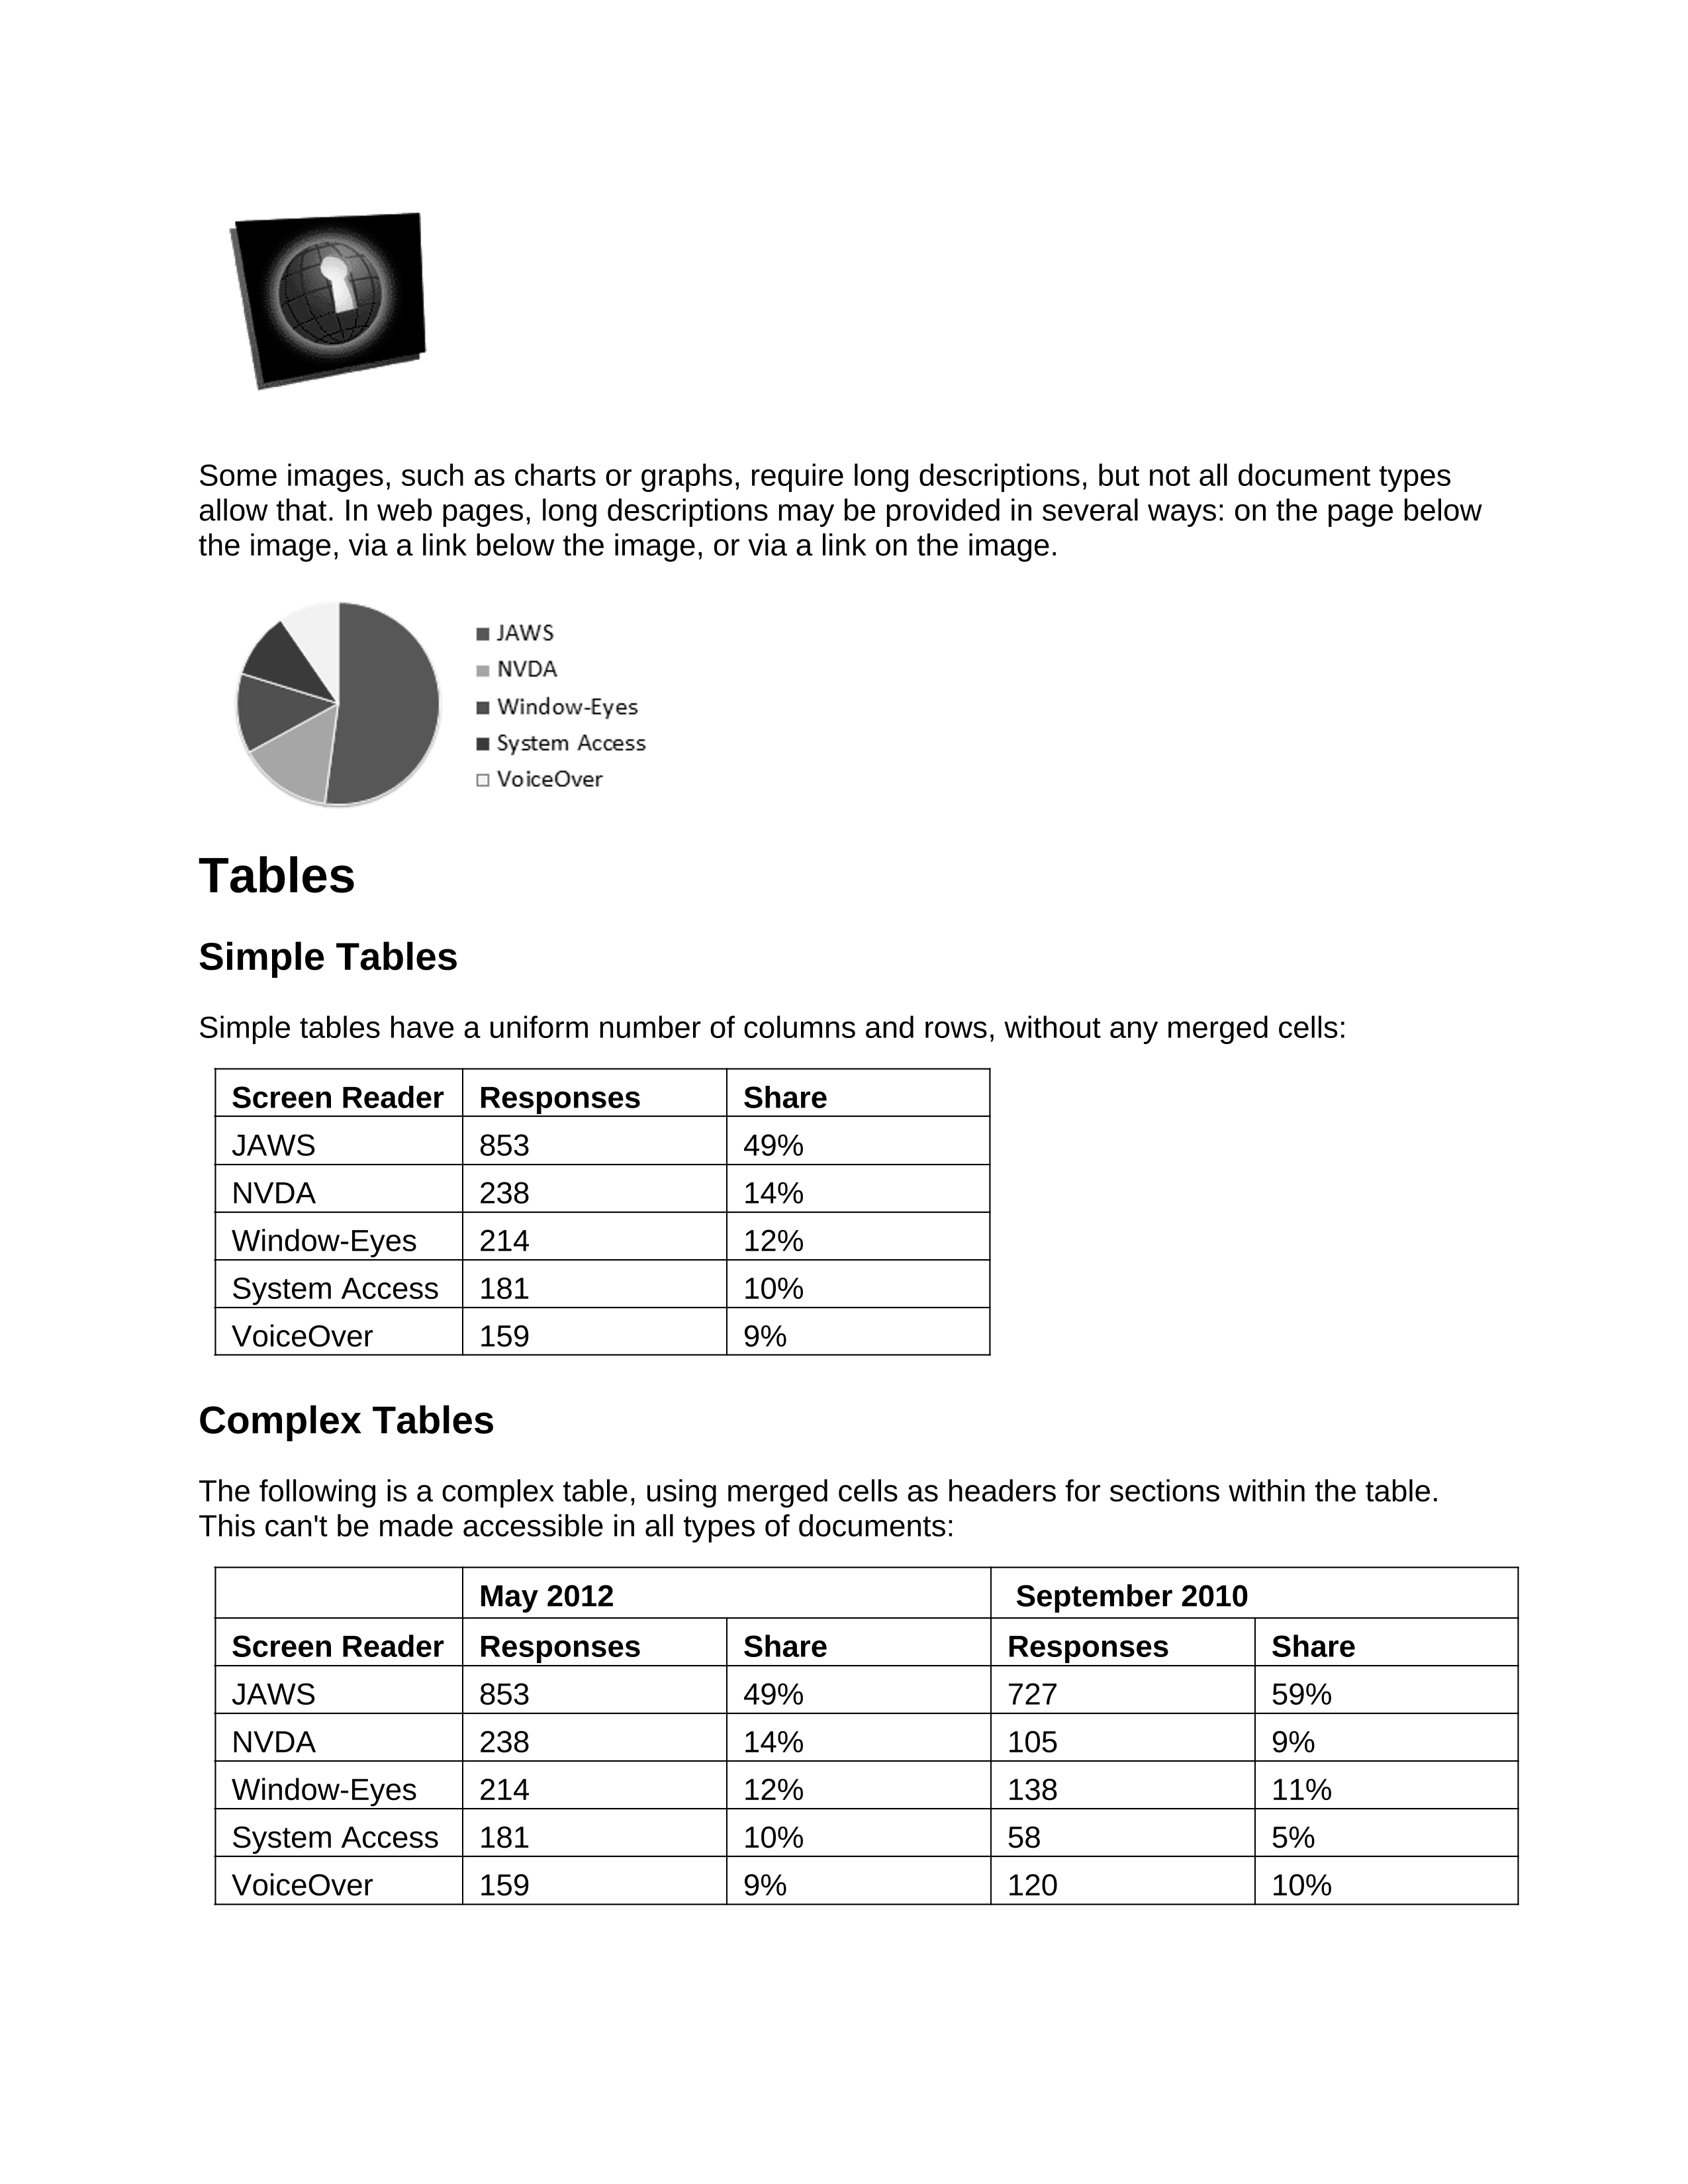

Image:
        origin: file:/root/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


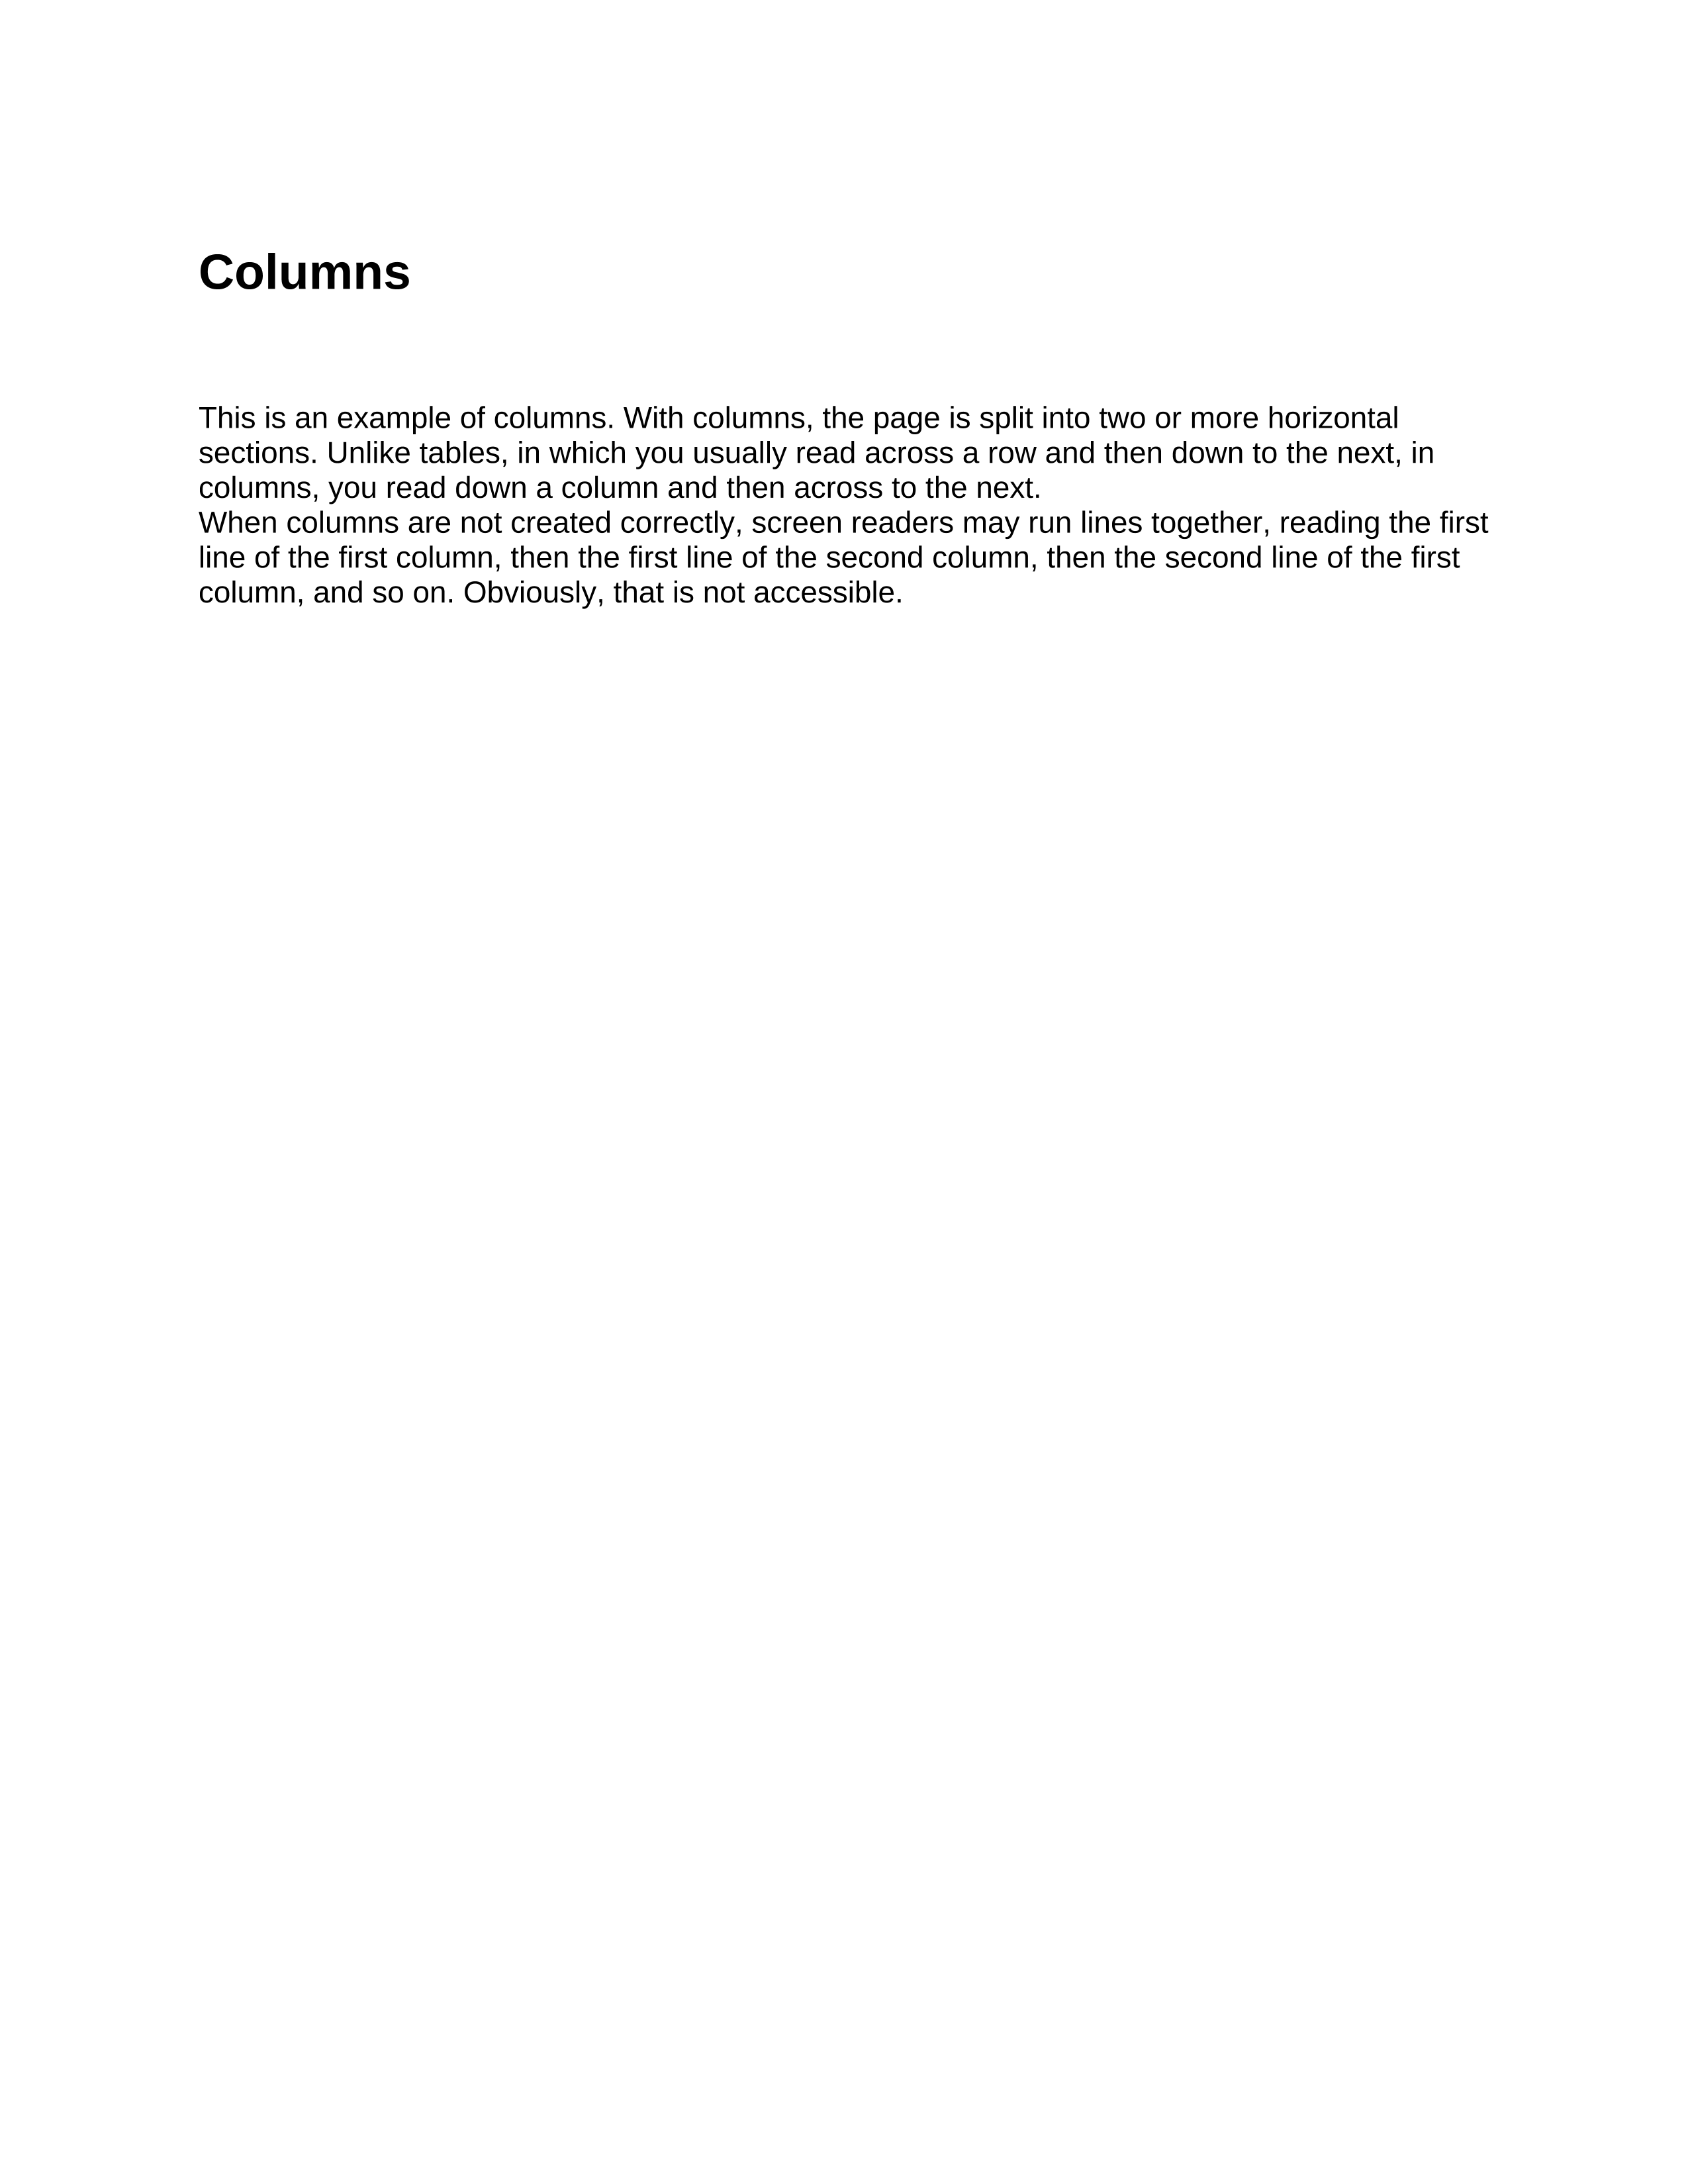

In [ ]:
image_df = PdfToImage().transform(DocToPdf().setOutputCol("content").transform(doc_example_df))
for r in image_df.select("image").collect():
    display_image(r.image)

#### Extract text using DocToText transformer

In [ ]:
doc_to_table = DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

result.show()

+--------------------+-------------------+------+--------------------+---------+
|                path|   modificationTime|length|              tables|exception|
+--------------------+-------------------+------+--------------------+---------+
|file:/root/.local...|2021-04-13 14:44:02| 33260|[[0, 0, 0.0, 0.0,...|     null|
|file:/root/.local...|2021-04-13 14:44:02| 33260|[[1, 0, 0.0, 0.0,...|     null|
+--------------------+-------------------+------+--------------------+---------+



In [ ]:
result.select(result["tables.chunks"].getItem(3)["chunkText"]).show(truncate=False)

+-----------------------------------------+
|tables.chunks AS chunks#7105[3].chunkText|
+-----------------------------------------+
|[Window-Eyes, 214, 12%]                  |
|[NVDA, 238, 14%, 105, 9% ]               |
+-----------------------------------------+



#### Display extracted data in JSON format

In [ ]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 0.0,
            "y": 0.0,
            "width": 0.0,
            "height": 0.0
        },
        "chunks": [
            [
                {
                    "chunkText": "Screen Reader",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 90.0,
                    "height": 0.0
                },
                {
                    "chunkText": "Responses",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                },
                {
                    "chunkText": "Share",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                }
            ],
            [
                {
                    "chunkText": "JAWS",
                    "x": 0.0,
                    "

# Text to Pdf

In [ ]:
def pipeline():
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setKeepInput(True)
    
    # Run OCR
    ocr = ImageToText() \
        .setInputCol("image") \
        .setOutputCol("text") \
        .setConfidenceThreshold(60) \
        .setIgnoreResolution(False) \
        .setPageSegMode(PageSegmentationMode.SPARSE_TEXT)
    
    # Render results to PDF
    textToPdf = TextToPdf() \
        .setInputCol("positions") \
        .setInputImage("image") \
        .setOutputCol("pdf")

    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr,
        textToPdf
    ])
    
    return pipeline

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/test_document.pdf

In [ ]:
pdf_example_df = spark.read.format("binaryFile").load('test_document.pdf').cache()


In [ ]:
result = pipeline().transform(pdf_example_df).cache()

In [ ]:
result.columns

['path', 'text', 'pdf', 'exception']

In [ ]:
display_image(PdfToImage().transform(pdf_example_df).select("image").collect()[0].image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Store results to pdf file
pdf = result.select("pdf").head().pdf

pdfFile = open("result.pdf", "wb")

pdfFile.write(pdf)

pdfFile.close()

In [ ]:
# Convert pdf to image and display¶

image_df = PdfToImage() \
    .setInputCol("pdf") \
    .setOutputCol("image") \
    .transform(result.select("pdf", "path"))

for r in image_df.collect():
    display_image(r.image)


Output hidden; open in https://colab.research.google.com to view.

# Dicom Image Deidentifier 

## Deidentification Pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

In [ ]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [ ]:
# Convert to images
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw")

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(1000) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.gray)
    

# OCR pipeline
pipeline = Pipeline(stages=[
    binary_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


### Load Image

In [ ]:
import pkg_resources
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/p1.jpg')
image_df = spark.read.format("binaryFile").load(image_path)

### Run Pipeline

In [ ]:
result = pipeline.fit(image_df).transform(image_df).cache()

In [ ]:
result.select('text').show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Chunks to hide
result.select('ner_chunk').show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ner_chunk                                                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[chunk, 193, 202, 04/04/2018, [entity -> DATE, sentence -> 1, chunk -> 0], []], [chunk, 3388, 3397, 04/12/2018, [entity -> DATE, sentence -> 20, chunk -> 1], []]]|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [ ]:
# Coordinates of Chunks to Hide
result.select('coordinates').show(2, False)

+------------------------------------------------------------------------+
|coordinates                                                             |
+------------------------------------------------------------------------+
|[[0, 0, 356.0, 1053.0, 217.0, 41.0], [1, 0, 495.0, 3527.0, 231.0, 43.0]]|
+------------------------------------------------------------------------+



## Show original and deidentified images

In [ ]:
from sparkocr.utils import display_image, to_pil_image
import matplotlib.pyplot as plt

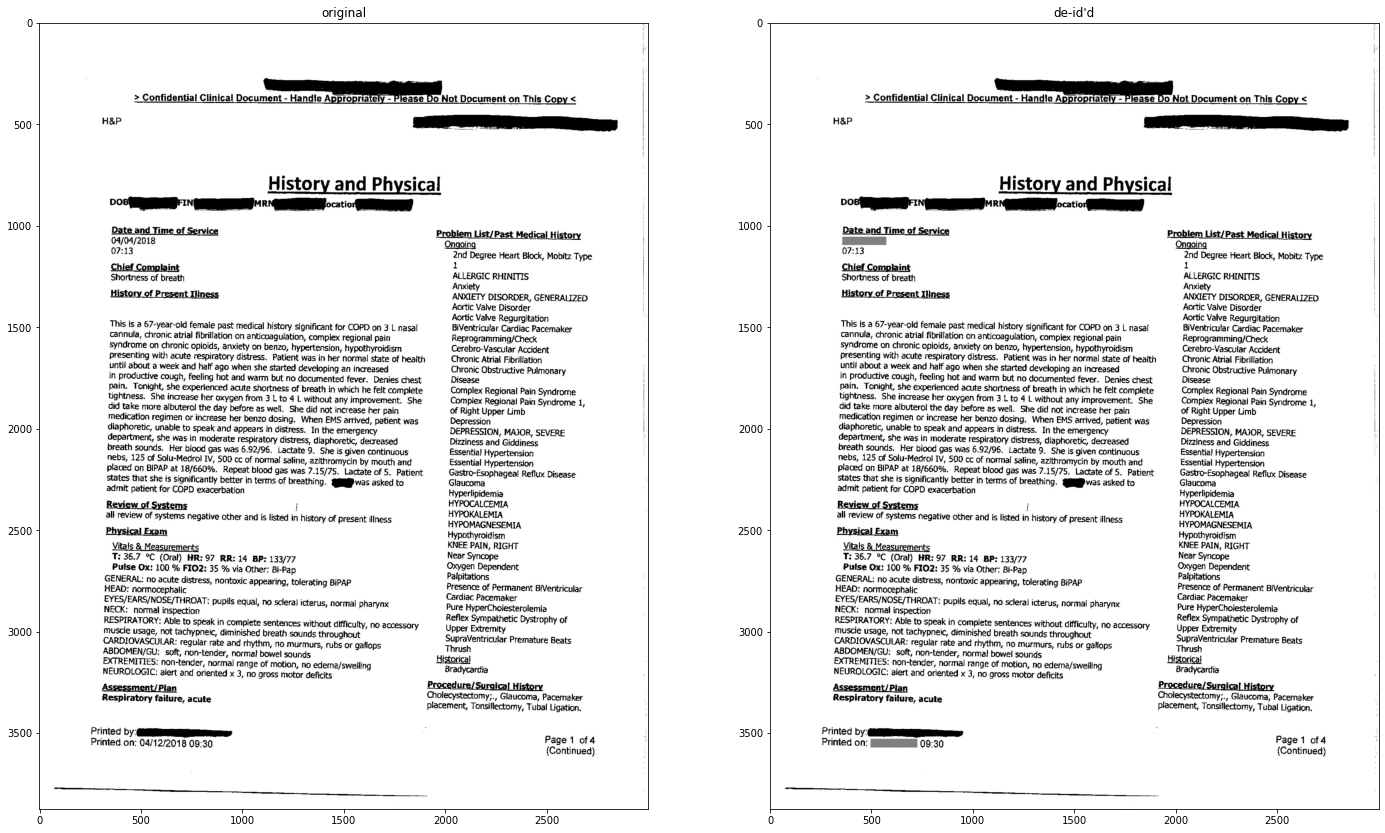

In [ ]:
for r in result.select("image_raw", "image_with_regions").collect():
    img_orig = r.image_raw
    img_deid = r.image_with_regions

    img_pil_orig = to_pil_image(img_orig, img_orig.mode)
    img_pil_deid = to_pil_image(img_deid, img_deid.mode)

    plt.figure(figsize=(24,16))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pil_orig, cmap='gray')
    plt.title('original')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pil_deid, cmap='gray')
    plt.title("de-id'd")
    plt.show()

# Dicom to Image

In [ ]:
! mkdir dicom
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -O /content/dicom/dicom_1.dcm
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm  -O /content/dicom/dicom_2.dcm
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-2.dcm  -O /content/dicom/dicom_3.dcm

Image:
        origin: file:/content/dicom/dicom_1.dcm 
        width: 1520
        height: 841
        mode: 10


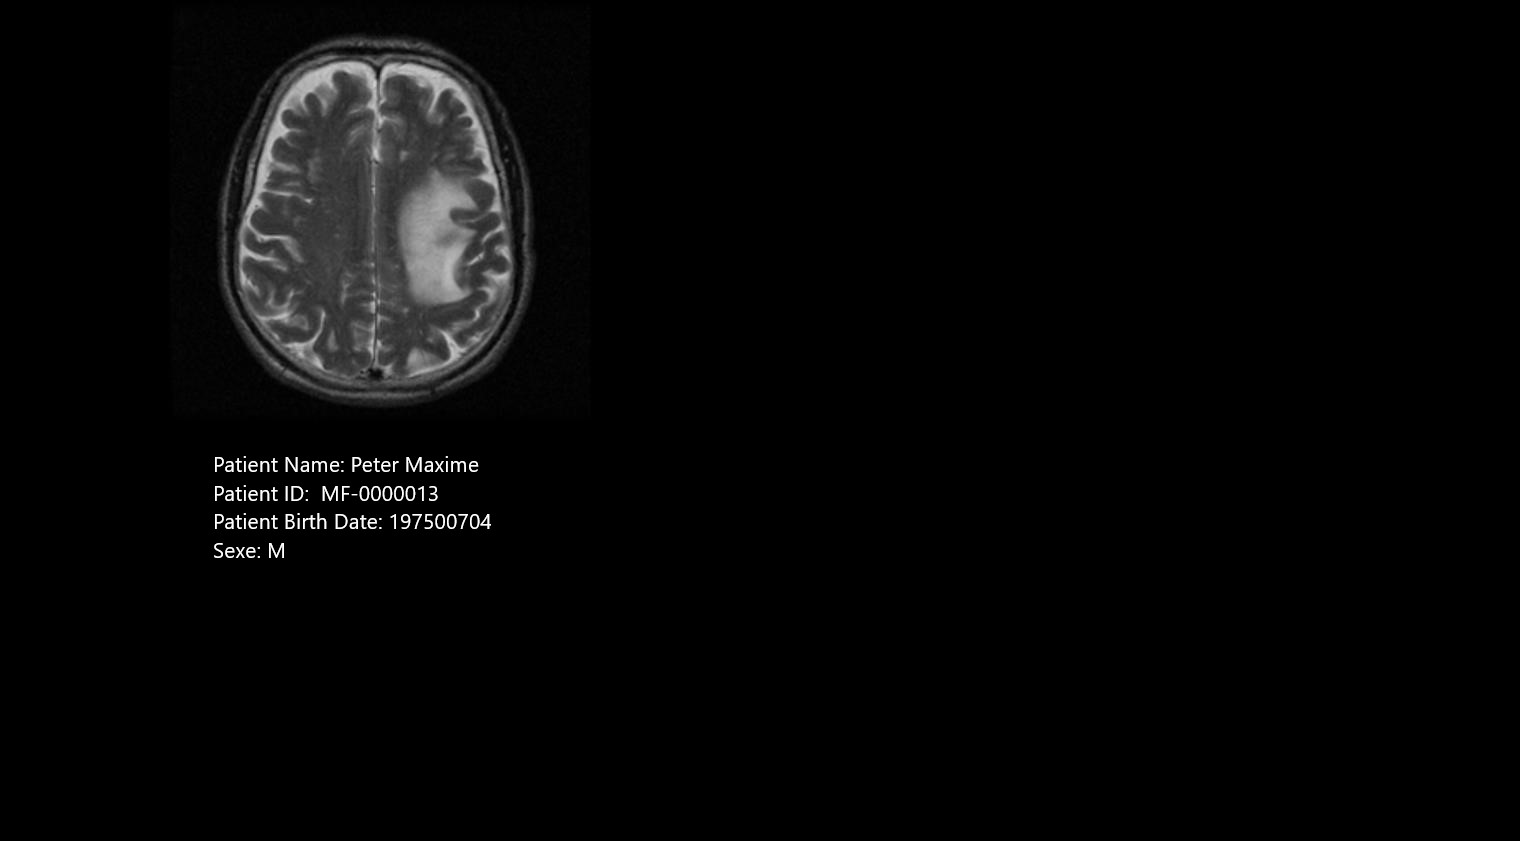

Image:
        origin: file:/content/dicom/dicom_1.dcm 
        width: 1520
        height: 841
        mode: 10


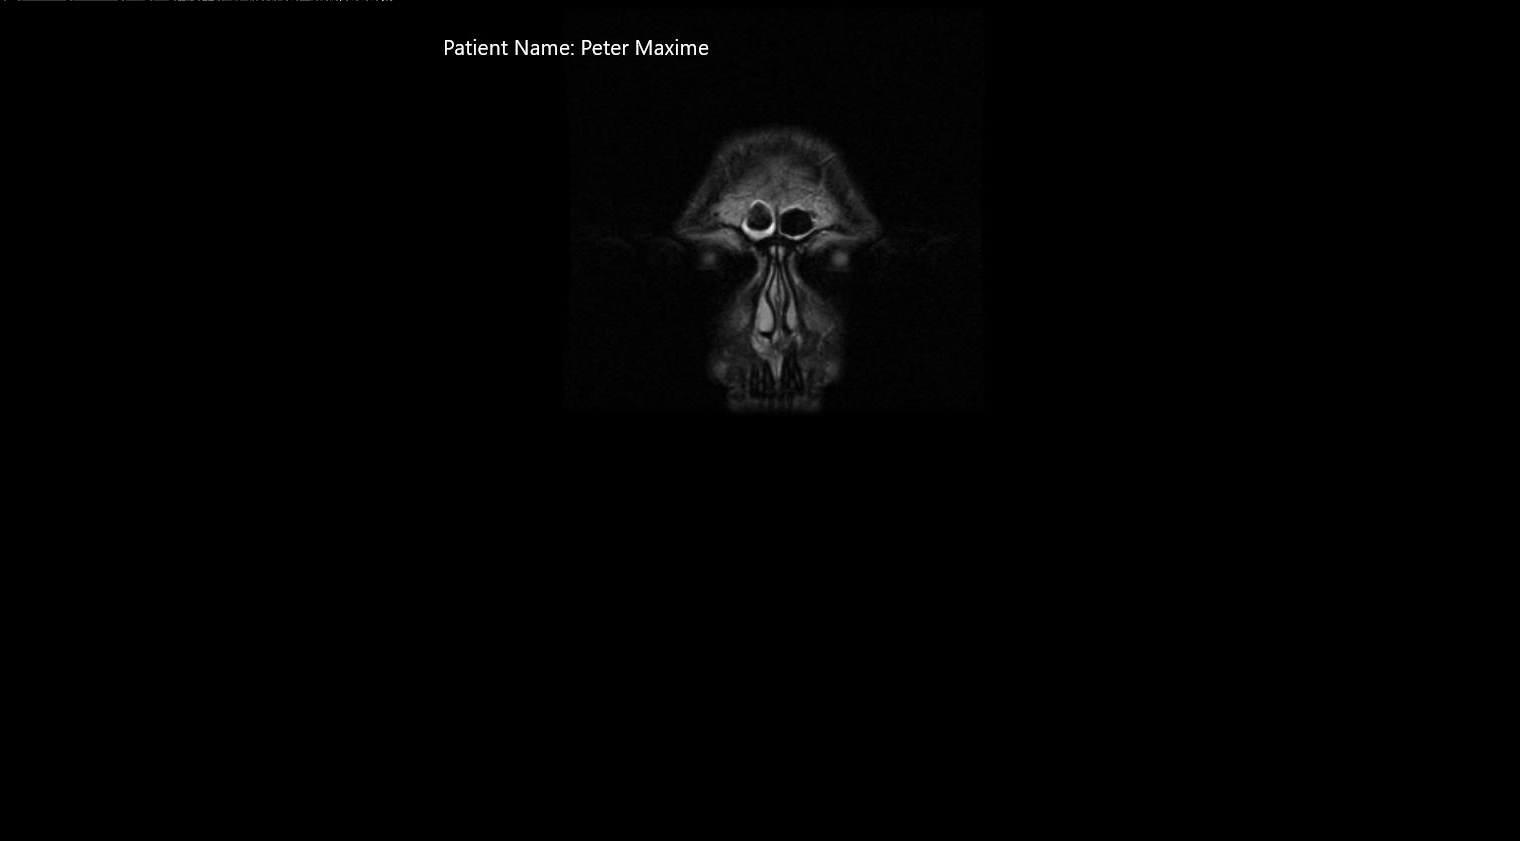

Image:
        origin: file:/content/dicom/dicom_1.dcm 
        width: 1520
        height: 841
        mode: 10


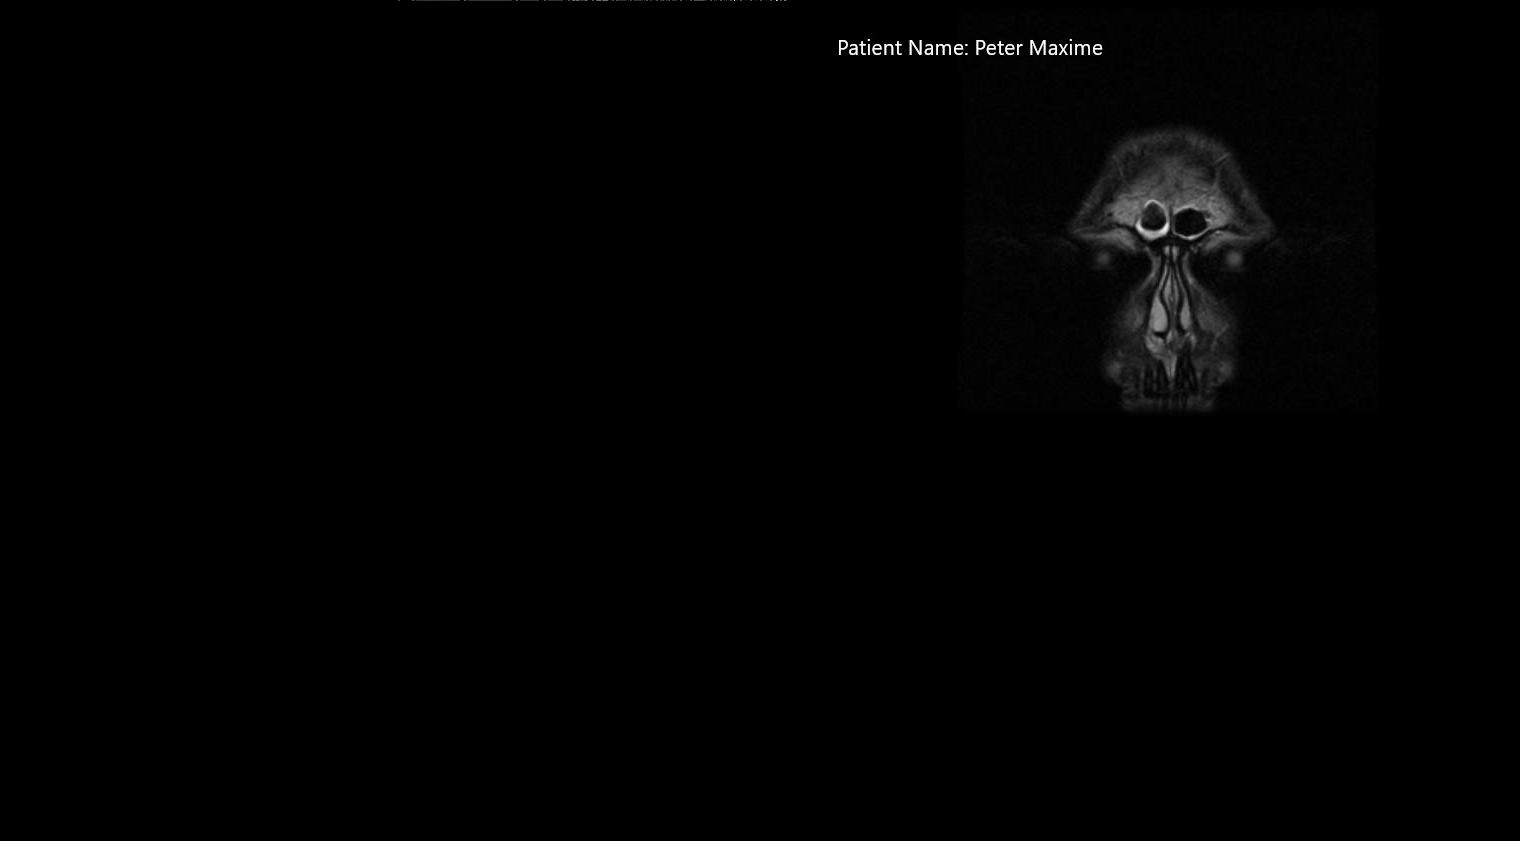

Image:
        origin: file:/content/dicom/dicom_3.dcm 
        width: 914
        height: 985
        mode: 10


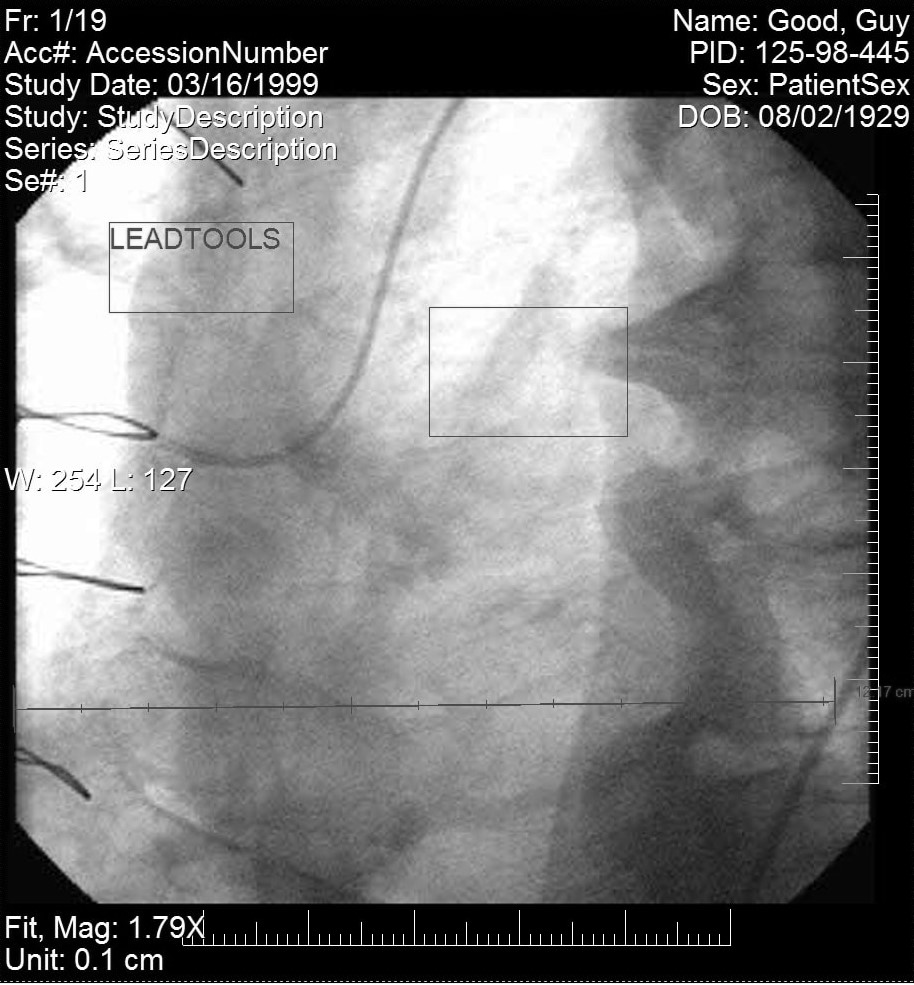

Image:
        origin: file:/content/dicom/dicom_2.dcm 
        width: 800
        height: 800
        mode: 10


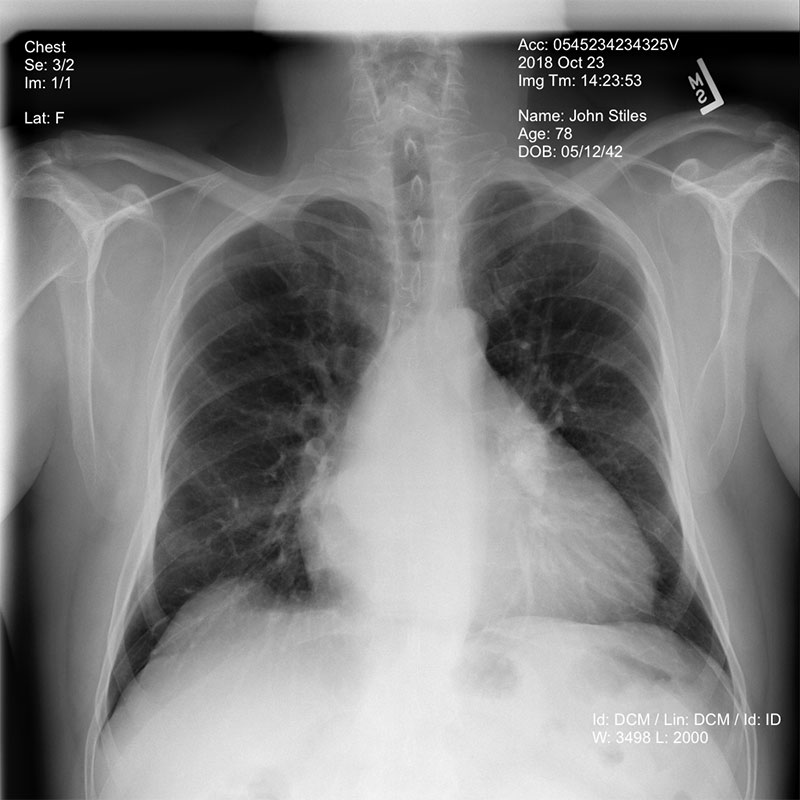

In [ ]:
dicom_path = './dicom/*.dcm'

# Read dicom file as binary file
dicom_df = spark.read.format("binaryFile").load(dicom_path)


dicomToImage = DicomToImage() \
  .setInputCol("content") \
  .setOutputCol("image") \
  .setMetadataCol("meta")

data = dicomToImage.transform(dicom_df)

for image in data.collect():
      display_image(image.image)



In [ ]:
# Extract text from image
ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


print("\n".join([row.text for row in ocr.transform(data).select("text").collect()]))


 

Palau
Patient ID: MF-0000013
Patient Birth Date: 197500704
Soa]

 

Pala a aC

 

 

Pala a aC

 

al oat TRS) Name: Good, Guy
(Nee: se Xe) ola elgg o]-18 PID: 125-98-445

Study Date: ore al 999 Sex: PatientSex
_ DOB:,08/02/1929

One)

 

LEADTOOLS

 

 

 

 

 

 

OA yer

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

 



# More example here

https://github.com/JohnSnowLabs/spark-ocr-workshop